<a href="https://colab.research.google.com/github/DarioDell/Multivariate_time_series/blob/main/Modelo_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desarrollo de un modelo VAR con series temporales multivariantes


1.   Análisis exploratorio de los datos.
2.   Dividir la serie en conjuntos de entrenamiento y prueba.
3.   Prueba de estacionariedad.
4.   Transformación de la serie de entrenamiento.
5.   Construcción de un modelo VAR sobre las series transformadas.
6.   Causalidad de Granger.
7.   Diagnóstico del modelo.
8.   Se realiza el pronóstico utilizando el modelo finalmente elegido.
9.   Transformación inversa del pronóstico a la escala original.
10.  Se lleva a cabo la evaluación del pronóstico.






# Datos: <u>commodity_futures.csv</u>

Se importará el dataset mensionado que lo he obtenido de la página web: https://www.kaggle.com/.<br>
El mismo contiene información sobre los valores de las 'commodities' más relevantes de Europa, desde el año 2000 hasta mediados del 2024.<br>
El <u>**OBJETIVO**</u> principal de este proyecto es el de crear un modelo VAR capaz que hacer pronósticos certeros. A este modelo se le pasarán datos de entrenamiento preparados, los cuales se utilizarán para ejercitarlo, reservando una muestra de datos (test) para luego contrastar los resultados obtenidos con los reales y obtener conclusiones claras sobre su rendimiento.<br>
El dataset cuenta con 23 variables, es un número elevado de columnas por lo cual he decidido eliminar algunas de ellas para no hacer tan extenso y tedioso el trabajo. El punto es realizar un proyecto que resulte tolerable y atractivo a los receptores, que no se desvie la atención ni que se torne denso.


In [ ]:
#Se importan las librerias necesarias para el proyecto

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from pandas.plotting import lag_plot
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_absolute_error, mean_squared_error

from google.colab import files
# files.download('gold.png')

In [ ]:
# Código para que los valores del dataframe contengan solo dos decimales

pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
df = pd.read_csv('commodity_futures.csv', parse_dates= ['Date'])
df

,Date,NATURAL GAS,GOLD,WTI CRUDE,BRENT CRUDE,SOYBEANS,CORN,COPPER,SILVER,LOW SULPHUR GAS OIL,...,ZINC,ULS DIESEL,NICKEL,WHEAT,SUGAR,GASOLINE,COFFEE,LEAN HOGS,HRW WHEAT,COTTON
0,2000-01-03,NaN,NaN,NaN,NaN,456.50,200.75,NaN,NaN,NaN,...,"1,237.50",NaN,"8,446.00",247.50,6.10,NaN,116.50,55.98,274.25,51.07
1,2000-01-04,2.18,283.70,25.55,24.39,464.25,203.00,0.85,5.38,213.50,...,"1,215.00",67.78,"8,314.00",247.25,5.77,NaN,116.25,55.62,274.00,50.73
2,2000-01-05,2.17,282.10,24.91,23.73,469.25,203.00,0.86,5.21,213.00,...,"1,209.25",66.55,"8,307.00",249.75,5.81,NaN,118.60,55.08,276.25,51.56
3,2000-01-06,2.20,282.40,24.78,23.62,468.00,203.75,0.85,5.17,211.25,...,"1,212.00",66.28,"8,252.00",248.50,5.77,NaN,116.85,55.17,275.00,52.08
4,2000-01-07,2.17,282.90,24.22,23.09,471.50,207.00,0.85,5.20,205.25,...,"1,209.25",64.75,"8,174.00",251.75,5.84,NaN,114.15,55.62,277.75,53.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6087,2023-07-31,2.63,"1,970.50",81.80,85.56,"1,445.75",504.00,4.01,24.97,877.25,...,"2,571.31",299.09,"22,127.00",665.75,24.11,292.90,164.65,104.12,812.75,85.44
6088,2023-08-01,2.56,"1,940.70",81.37,84.91,"1,446.75",497.00,3.91,24.33,911.50,...,"2,574.80",302.34,"22,189.00",652.25,24.39,287.30,164.55,103.67,804.50,86.87
6089,2023-08-02,2.48,"1,937.40",79.49,83.20,"1,429.75",488.25,3.84,23.87,884.50,...,"2,486.50",300.43,"21,379.00",640.00,24.20,277.58,166.95,102.67,787.00,85.08
6090,2023-08-03,2.56,"1,932.00",81.55,85.14,"1,428.75",480.75,3.90,23.70,899.50,...,"2,494.00",307.49,"21,402.00",627.00,24.02,276.47,164.75,101.00,767.50,85.28


In [ ]:
#Como menciono al comienzo, elimino las siguientes variables.
#Las he seleccionado debido a que no encontré información suficiente para determinar si el origen de dichos datos son pausibles o no.
#También hago hincapie en sostener aquellas variables con las que estamos más familiarizados en España.

df = df.drop(['ULS DIESEL'], axis=1)
df = df.drop(['NATURAL GAS'], axis=1)
df = df.drop(['HRW WHEAT'], axis=1)
df = df.drop(['SOYBEAN OIL'], axis=1)
df = df.drop(['SOYBEAN MEAL'], axis=1)
df = df.drop(['LOW SULPHUR GAS OIL'], axis=1)
df = df.drop(['WTI CRUDE'], axis=1)
df = df.drop(['BRENT CRUDE'], axis=1)
df = df.drop(['LIVE CATTLE'], axis=1)
df = df.drop(['LEAN HOGS'], axis=1)

Las variables con las que voy a trabajar se pueden clasificar en cuatro grupos:<br>



1.   <u>Industrial metals (metales industriales):</u>
*   COPPER(cobre)
*   ALUMINIUM
*   ZINC
*   NICKEL(níquel)<br><br>




2.   <u>Precious metals (metales preciosos):</u>
*   GOLD(oro)
*   SILVER(plata)<br><br>


3.   <u>Grain (granos):</u>
*   CORN(maiz)
*   SOYBEANS(soja)
*   WHEAT(trigo)<br><br>


4.   <u>Softs(commodities 'suaves'):</u>
*   SUGAR(azucar)
*   COFFEE(café)
*   COTTON(algodón)













In [ ]:
df.dtypes

,0
Date,datetime64[ns]
GOLD,float64
SOYBEANS,float64
CORN,float64
COPPER,float64
SILVER,float64
ALUMINIUM,float64
ZINC,float64
NICKEL,float64
WHEAT,float64


In [ ]:
# Establezco la variable 'Date' como indice del dataframe

df = df.set_index('Date')
df.tail()

,GOLD,SOYBEANS,CORN,COPPER,SILVER,ALUMINIUM,ZINC,NICKEL,WHEAT,SUGAR,GASOLINE,COFFEE,COTTON
Date,,,,,,,,,,,,,
2023-07-31,"1,970.50","1,445.75",504.00,4.01,24.97,"2,256.51","2,571.31","22,127.00",665.75,24.11,292.90,164.65,85.44
2023-08-01,"1,940.70","1,446.75",497.00,3.91,24.33,"2,221.06","2,574.80","22,189.00",652.25,24.39,287.30,164.55,86.87
2023-08-02,"1,937.40","1,429.75",488.25,3.84,23.87,"2,170.01","2,486.50","21,379.00",640.00,24.20,277.58,166.95,85.08
2023-08-03,"1,932.00","1,428.75",480.75,3.90,23.70,"2,188.00","2,494.00","21,402.00",627.00,24.02,276.47,164.75,85.28
2023-08-04,"1,939.00","1,441.00",482.50,3.86,23.68,NaN,NaN,NaN,632.00,23.78,277.45,162.55,85.48


<Axes: >

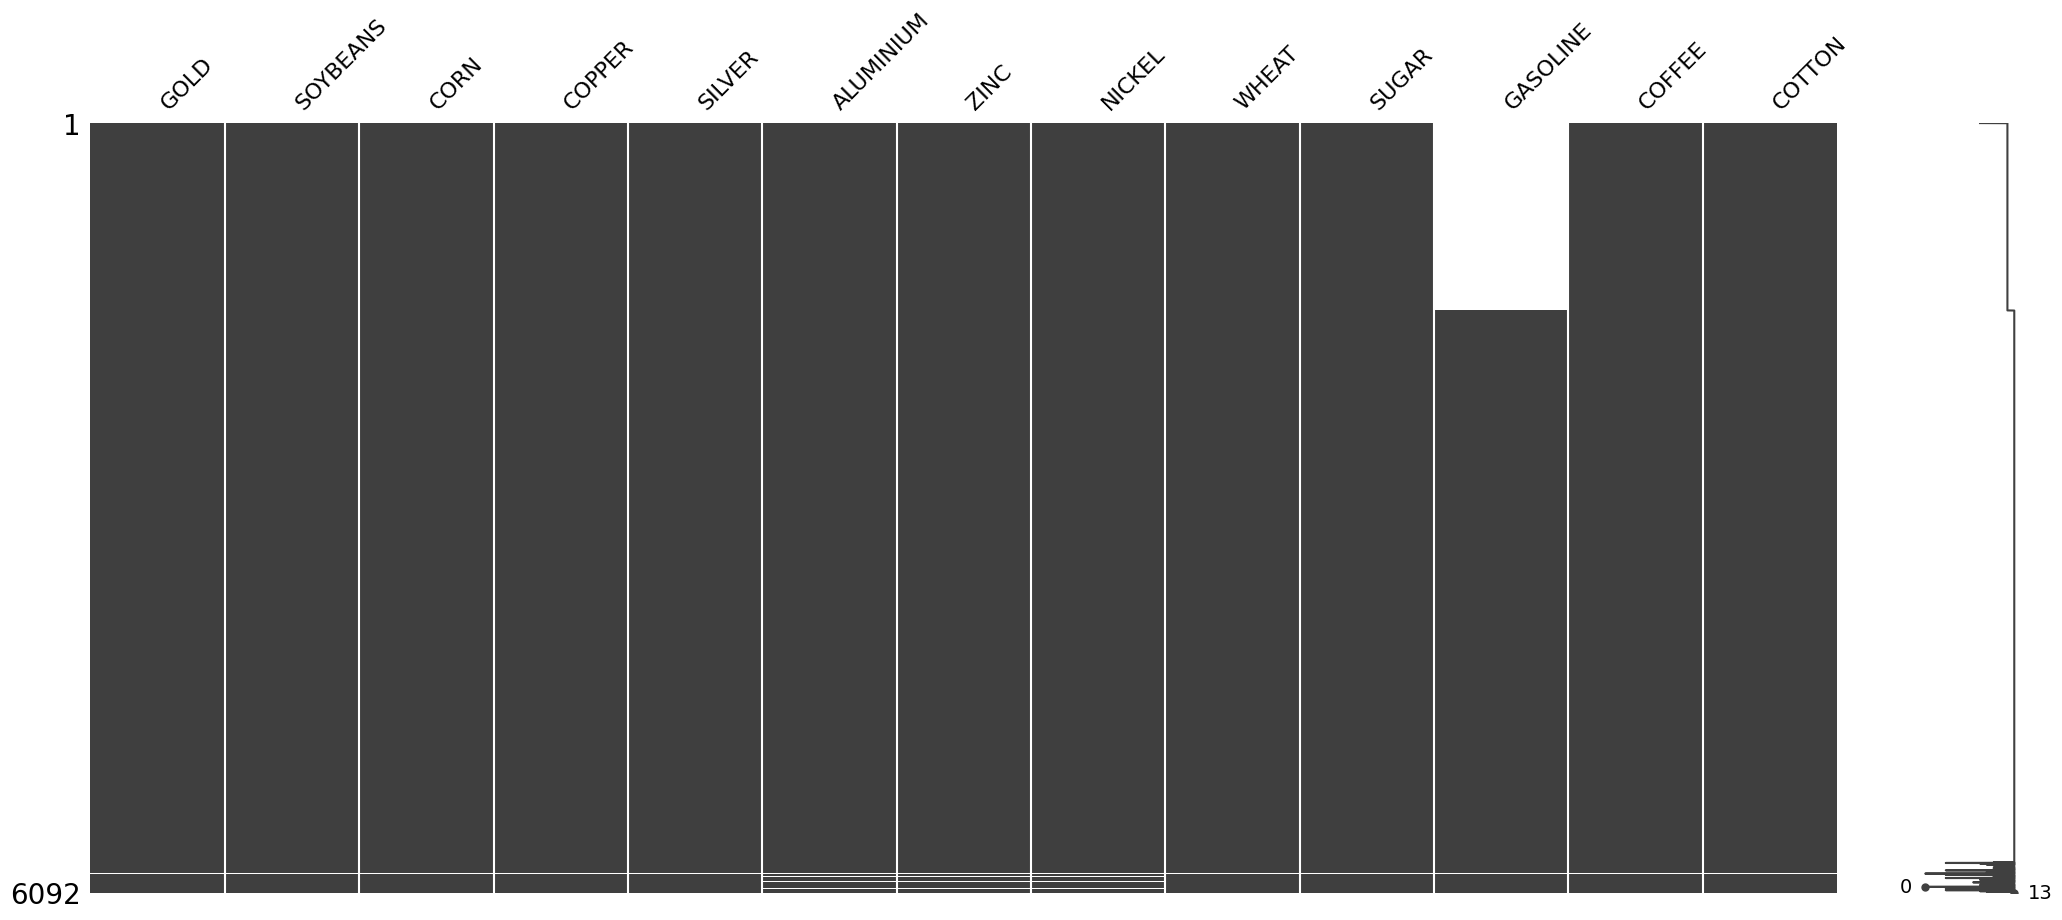

In [ ]:
# Grafico una visualización para chequear a simple vista si hay valores nulos
# 'GASOLINE' tiene un alto contenido de NaNs

msno.matrix(df)

In [ ]:
#En este dataframe se observa cuantitativamente el faltante de datos por columna

pd.DataFrame(df.isna().sum(), columns = ['Missings'])

,Missings
GOLD,10
SOYBEANS,9
CORN,8
COPPER,9
SILVER,13
ALUMINIUM,47
ZINC,46
NICKEL,46
WHEAT,14
SUGAR,9


In [ ]:
#Decido eliminar la variable 'GASOLINE' debido a que le faltan 1491 datos

df = df.drop(['GASOLINE'], axis=1)


In [ ]:
# Con este código cambio la frecuencia de los datos a días hábiles (business days).
# Ya que estoy trabajando con datos del mercado los cuales se obtienen de lunes a viernes, exeptuando días festivos.

df = df.asfreq('b')

In [ ]:
#back fill utiliza la siguiente observación valida para llenar el espacio de los NaN

df = df.fillna(method = 'bfill')
df.isna().sum()

<ipython-input-11-4bfdda45e2bb>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'bfill')


,0
GOLD,0
SOYBEANS,0
CORN,0
COPPER,0
SILVER,0
ALUMINIUM,1
ZINC,1
NICKEL,1
WHEAT,0
SUGAR,0


In [ ]:
#Como aún me han quedado 3 datos faltantes, lo que hago es rellenar ese espacio con la media de cada columna en cuestión

df['ALUMINIUM'].fillna(value= df['ALUMINIUM'].mean(), inplace=True)
df['ZINC'].fillna(value= df['ZINC'].mean(), inplace=True)
df['NICKEL'].fillna(value= df['NICKEL'].mean(), inplace=True)

In [ ]:
#Ya no quedan valores nuloss

df.isna().sum()

,0
GOLD,0
SOYBEANS,0
CORN,0
COPPER,0
SILVER,0
ALUMINIUM,0
ZINC,0
NICKEL,0
WHEAT,0
SUGAR,0


In [ ]:

df1  = df.copy()
df1.columns

Index(['GOLD', 'SOYBEANS', 'CORN', 'COPPER', 'SILVER', 'ALUMINIUM', 'ZINC',
       'NICKEL', 'WHEAT', 'SUGAR', 'COFFEE', 'COTTON'],
      dtype='object')

In [ ]:
# Genero un resumen estadístico del dataframe, lo hago en dos partes por mayor comodidad

df1[['GOLD','SILVER','COPPER','ALUMINIUM','ZINC', 'NICKEL']].describe()

,GOLD,SILVER,COPPER,ALUMINIUM,ZINC,NICKEL
count,"6,155.00","6,155.00","6,155.00","6,155.00","6,155.00","6,155.00"
mean,"1,069.20",16.12,2.62,"1,976.95","2,088.72","16,187.24"
std,533.51,8.45,1.13,452.02,849.26,"7,762.13"
min,255.10,4.03,0.61,"1,246.00",724.00,"4,350.00"
25%,492.60,8.21,1.66,"1,632.50","1,308.25","10,660.38"
50%,"1,202.30",16.27,2.85,"1,883.25","2,082.00","14,708.50"
75%,"1,474.25",20.68,3.45,"2,275.12","2,637.00","19,429.50"
max,"2,055.70",48.58,4.93,"3,875.50","4,594.00","53,750.00"


In [ ]:
df1[['CORN','SOYBEANS','WHEAT','SUGAR', 'COFFEE','COTTON']].describe()

,CORN,SOYBEANS,WHEAT,SUGAR,COFFEE,COTTON
count,"6,155.00","6,155.00","6,155.00","6,155.00","6,155.00","6,155.00"
mean,403.89,981.50,528.17,14.48,128.63,71.29
std,165.30,343.63,190.46,5.87,50.70,25.17
min,174.75,418.00,233.50,4.65,41.50,28.52
25%,251.50,663.88,378.00,9.94,99.28,55.53
50%,369.00,957.00,505.00,13.64,121.15,66.83
75%,514.38,"1,285.38",653.75,18.24,150.90,81.81
max,831.25,"1,771.00","1,425.25",35.31,304.90,215.15


# Análisis exploratorios de los datos

In [ ]:
list = ['GOLD', 'SOYBEANS', 'CORN', 'COPPER', 'SILVER',
       'ALUMINIUM', 'ZINC','NICKEL', 'WHEAT', 'SUGAR', 'COFFEE',
       'COTTON']

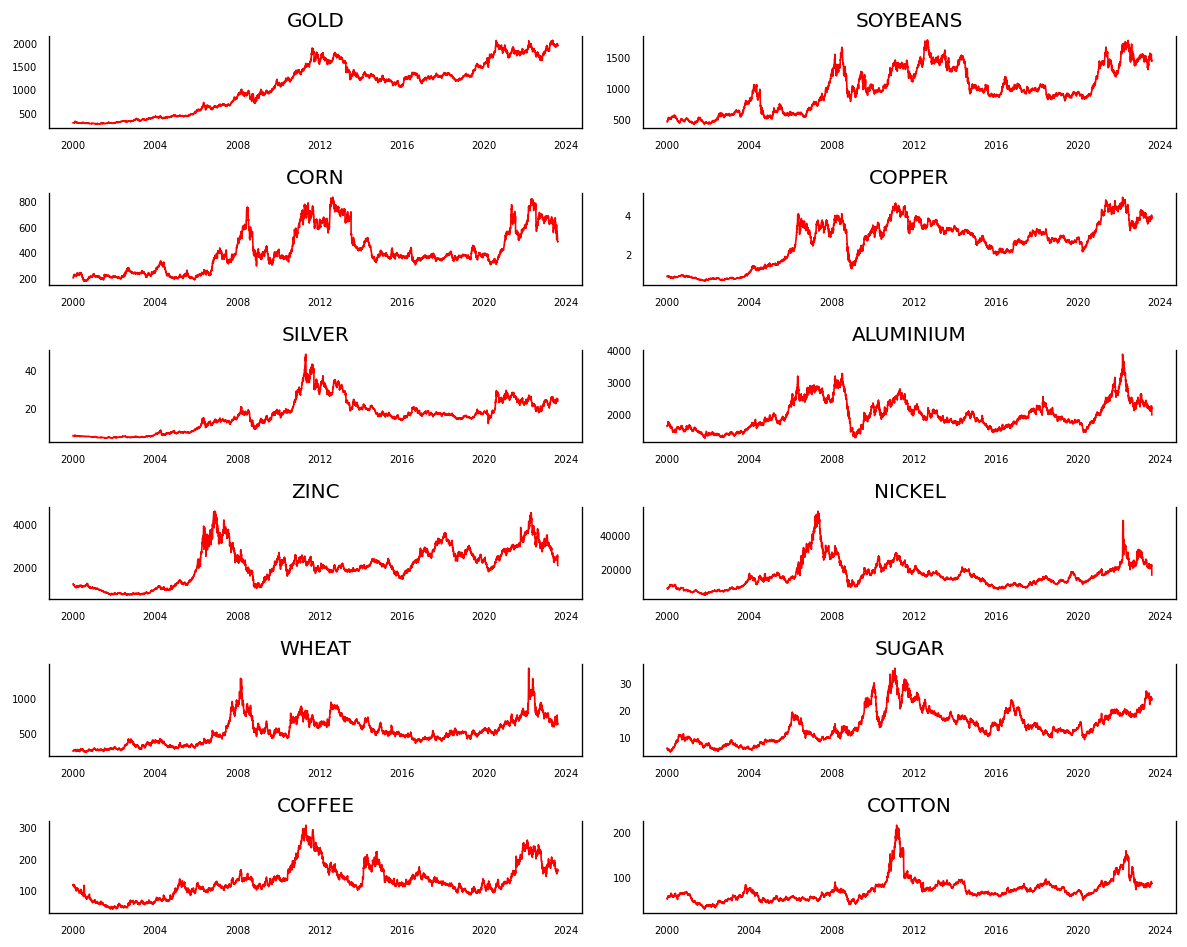

In [ ]:
# A continuación se visualizan las series de tiempo:

fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
 data = df1[df1.columns[i]]
 ax.plot(data, color='red', linewidth=1)
 ax.set_title(df1.columns[i])
 ax.xaxis.set_ticks_position('none')
 ax.yaxis.set_ticks_position('none')
 ax.spines['top'].set_alpha(0)
 ax.tick_params(labelsize=6)
 plt.tight_layout()


 # A simple vista se observa en la mayoria de los gráficos una tendencia creciente similar, coincidiendo en algunas fechas.
 # Puede que estén correlacionadas.

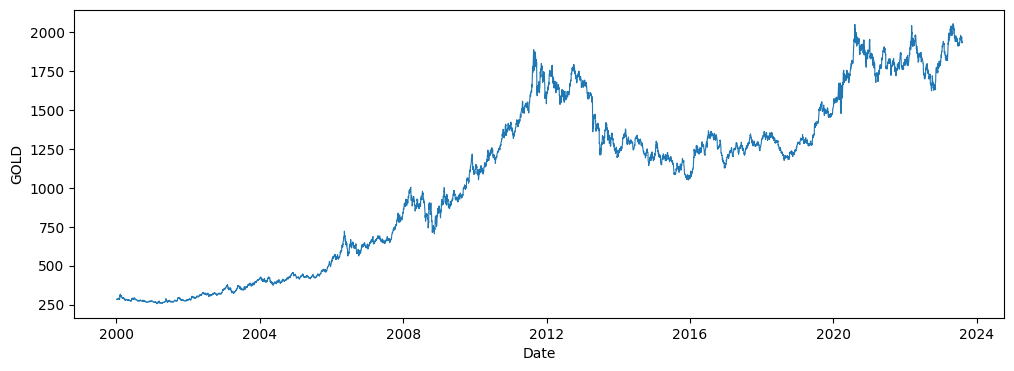

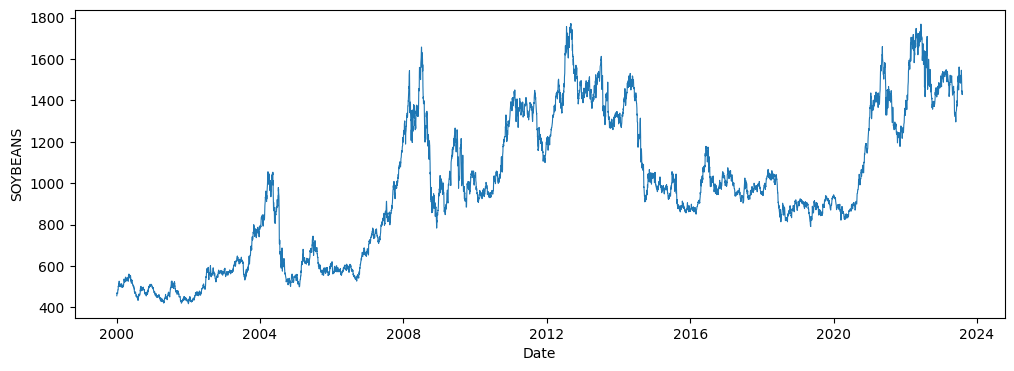

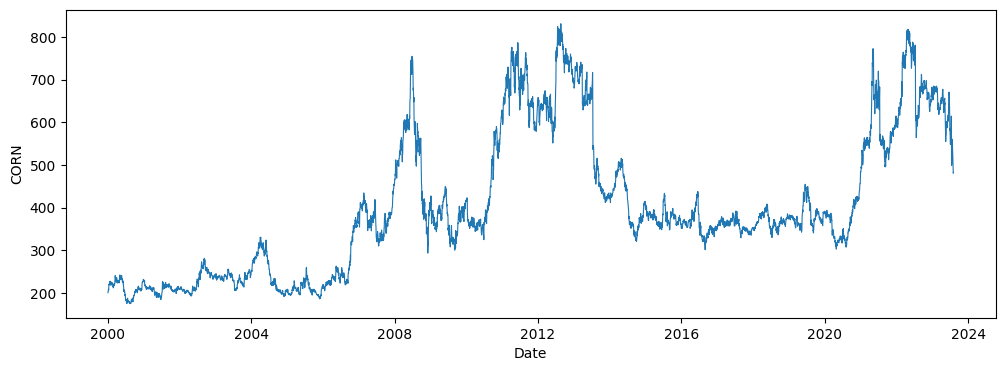

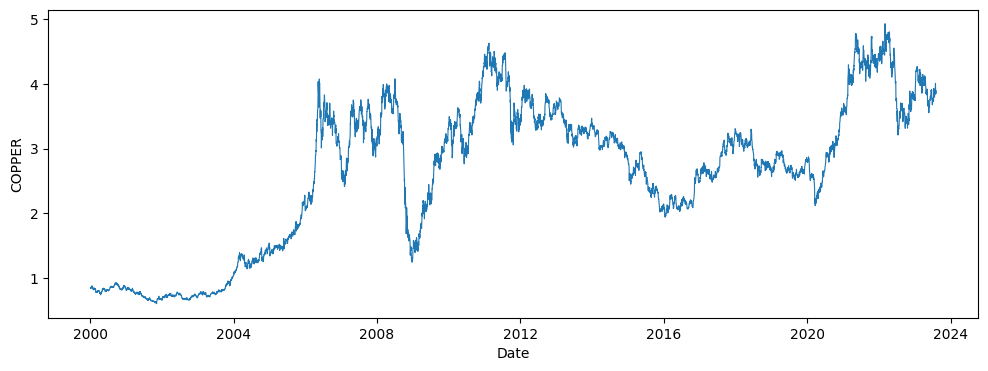

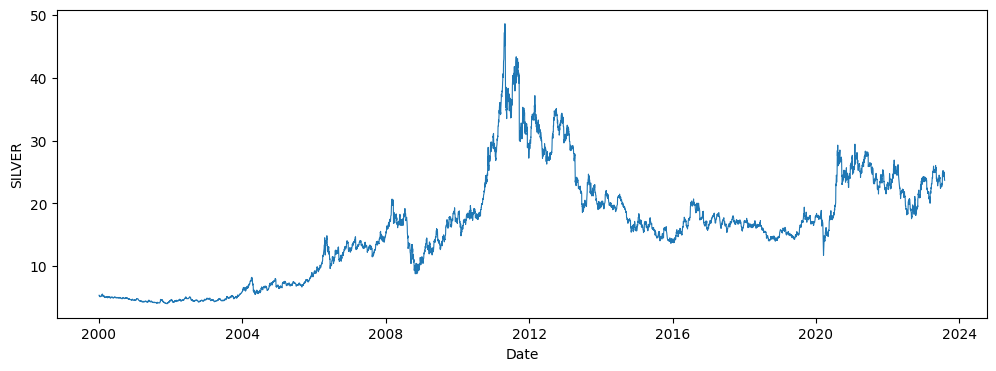

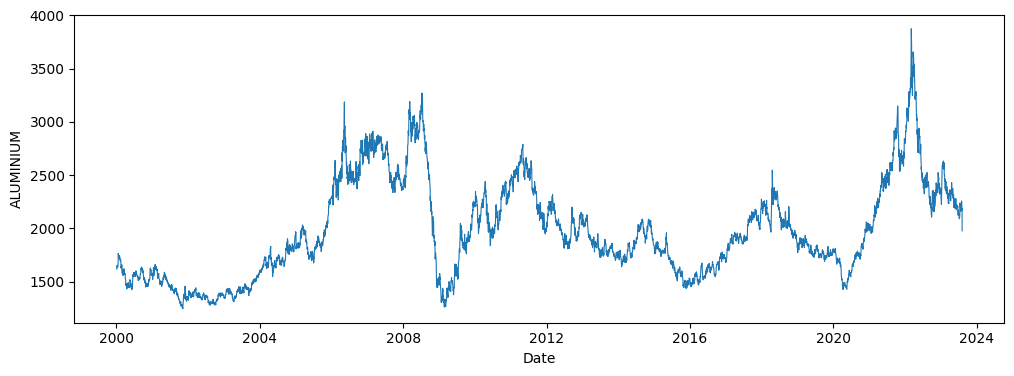

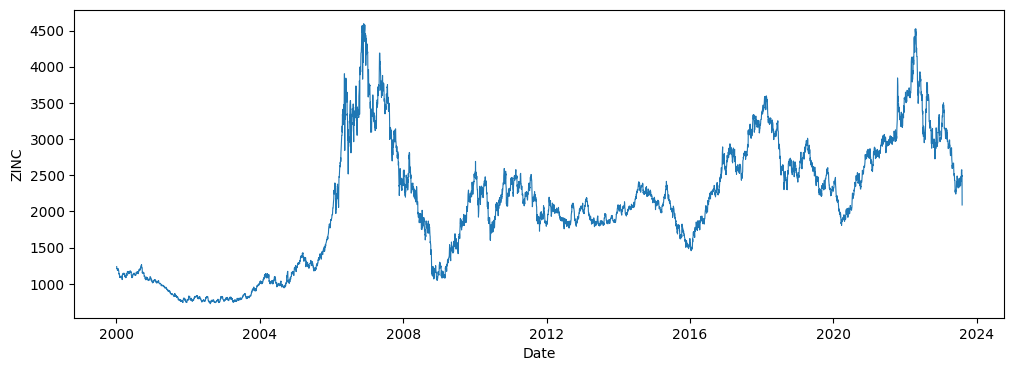

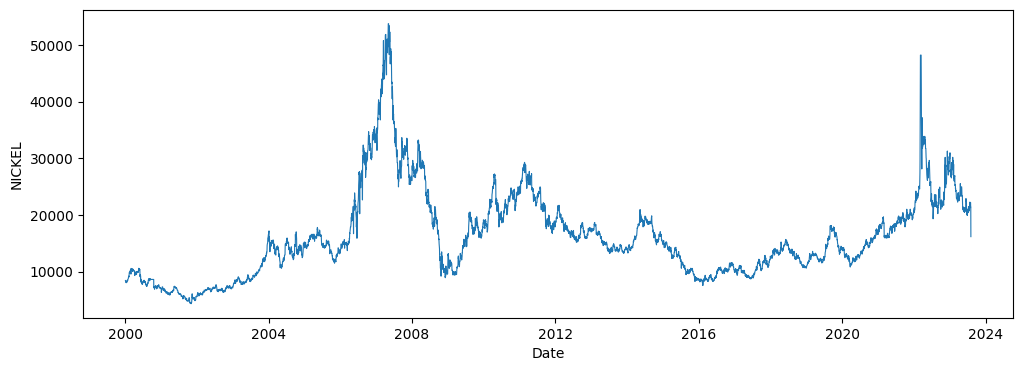

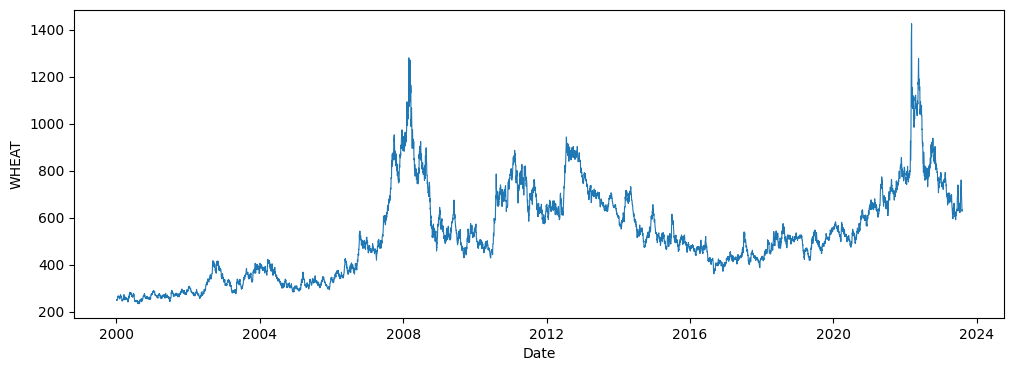

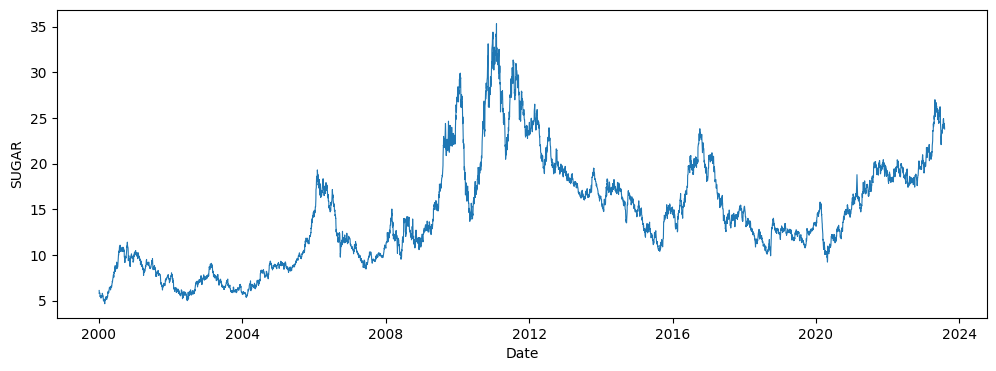

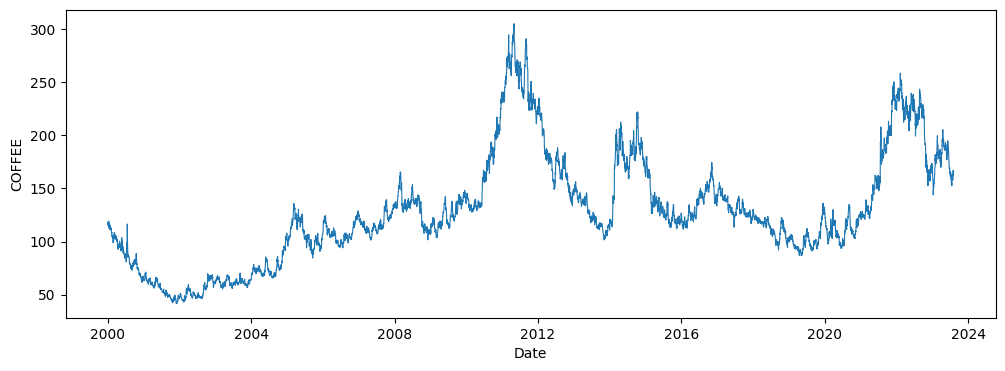

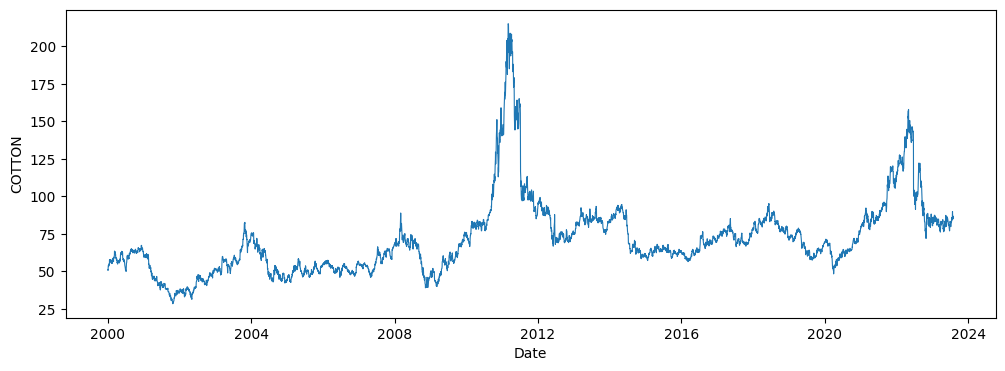

In [ ]:
# Aquí represento los gráficos individuales para observarlos de manera más particular utilizando la libreria de 'seaborn'

for i in list:
  fig, ax = plt.subplots(figsize = (12,4))
  sns.lineplot(data = df1, y= i, x= 'Date', linewidth= .8)
  plt.show()

Selecciono la variable <u>'GOLD'</u> para hacer un análisis más detallado.<br>
En este conjunto de datos el precio del oro se encuentra estipulado en "onza troy", medida utilizada principalmente en el mercado de metales preciosos, como el oro, la plata y el platino. Para tener una referencia: 1 onza troy equivale a 31.10 gramos.<br> Hay que tener en cuenta que el oro es el bien preciado por exelencia sobre caulquier otro a lo largo de la historia. Esto se debe a varios factores, entre los que se destacan:
* Su durabilidad
* Su escasez y valor intrínseco
* Aceptación universal
* Estabilidad de valor que se mantiene a traves de los siglos

Debido a estas características, el oro ha sido tradicionalmente utilizado como medio de intercambio y como una reserva de valor en tiempos de incertidumbre económica o crisis financieras. Sin embargo, es importante tener en cuenta que, si bien el oro ha desempeñado históricamente un papel fundamental como bien de cambio más apreciado, su relevancia en la economía moderna puede verse afectada por factores como la evolución de los sistemas financieros, tecnológicos y regulatorios.

* Durante 2000-2011 se observa un aumento gradual. Se contempla el primer pico notorio en 2008, año en el que estalla una crisis económica global con un impacto significativo para Europa. El oro experimentó un aumento en su valor debido a su condición de activo seguro, ya que los inversores buscaban refugio en medio de la incertidumbre económica.
* Durante 2011-2013 se observan picos destacables. A mediados del 2011 el precio del oro alcanzó niveles record en Europa, superando los $1900 por onza debido a la crisis de la deuda soberana en la eurozona y la incertidumbre económica global.<br>
* En los años siguientes y hasta el 2015 el precio experimentó correcciones a la baja, se cree que debido a la fortaleza del dólar y las expectativas de un endurecimiento de la política monetaria en Estados Unidos.
* Durante 2015-2020 el precio del oro mostró cierta estabilidad, pero también experimentó repuntes en respuesta a eventos como el Brexit (en el 2016), generando incertidumbre política y económica en Europa.
* 2020 en adelante: La pandemia de COVID-19 en 2020 impulsó una fuerte demanda de oro como activo refugio, lo que resultó en un aumento significativo de su precio en Europa y en todo el mundo. El precio del oro experimentó una amplia escalada en Europa, alcanzando nuevos máximos históricos debido a la incertidumbre económica, los estímulos fiscales y monetarios sin precedentes y las preocupaciones sobre la inflación.<br>
A modo de resumen, se puede establecer que durante los últimos 20 años, el precio del oro ha percibido una tendencia alcista general en Europa, impulsada por factores como la incertidumbre económica, la debilidad del dólar, las políticas monetarias y fiscales, así como eventos geopolíticos significativos.

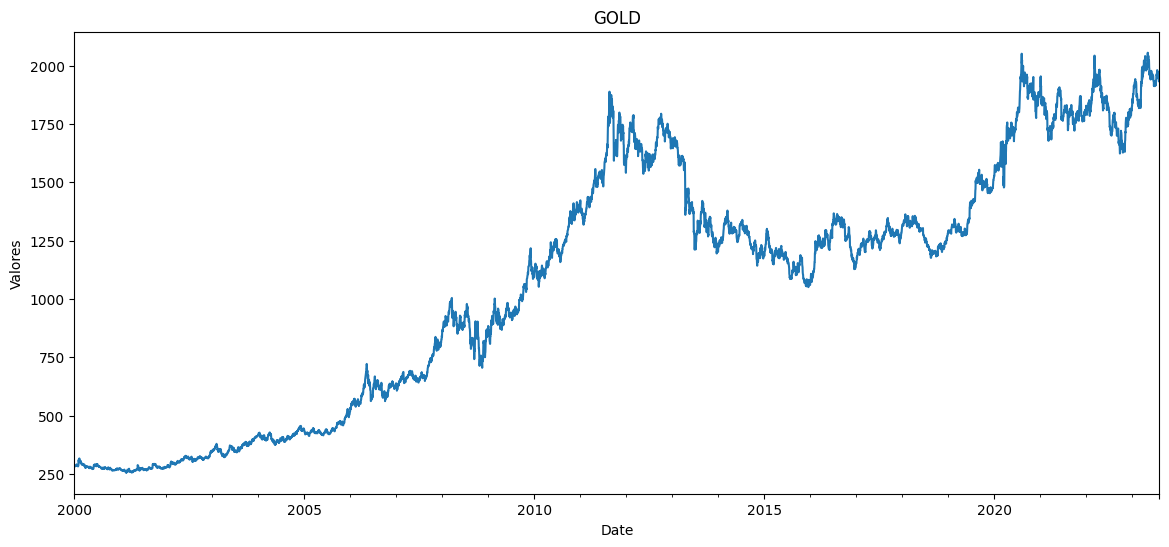

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))

df1.GOLD.plot(ax=ax, color='C0', legend=False)

ax.set_ylabel('Valores')
ax.set_title('GOLD');

GOLD


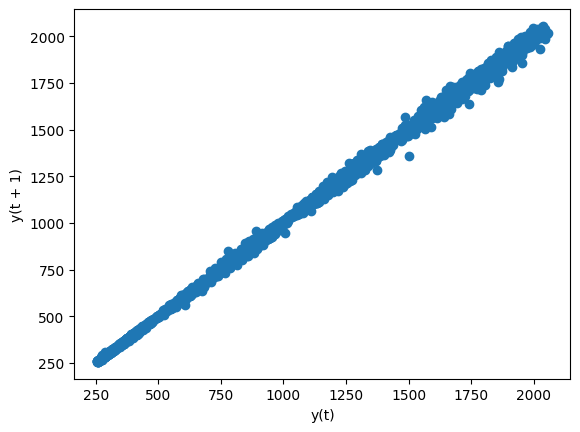

SOYBEANS


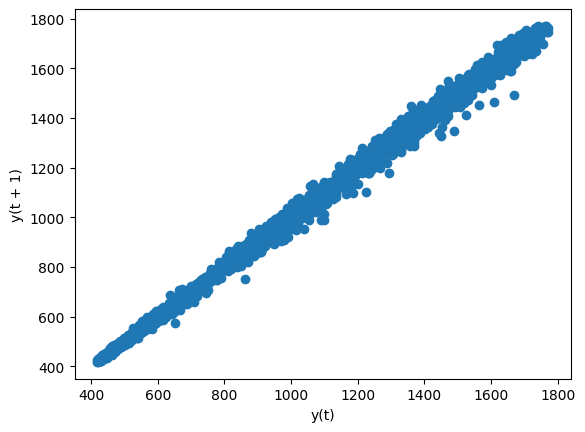

CORN


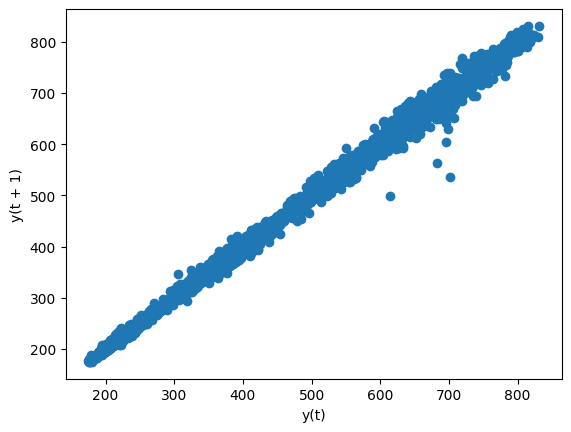

COPPER


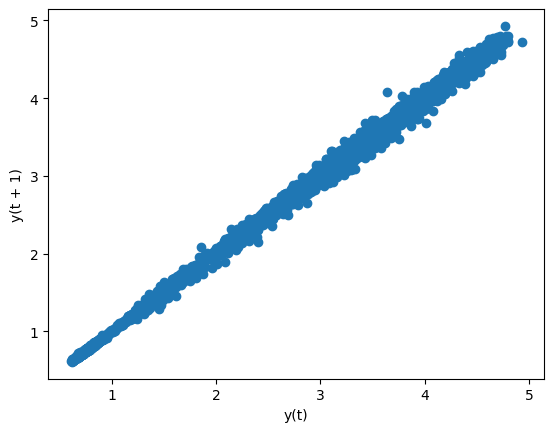

SILVER


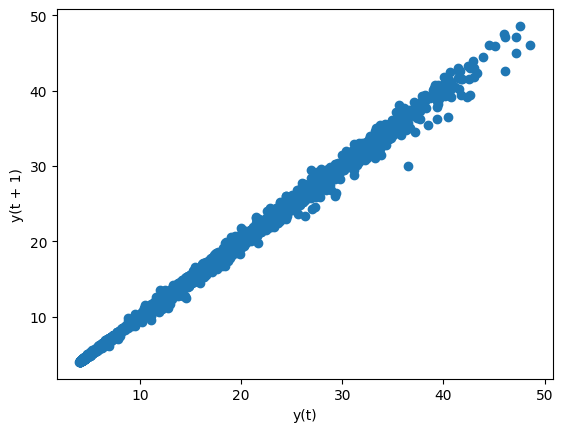

ALUMINIUM


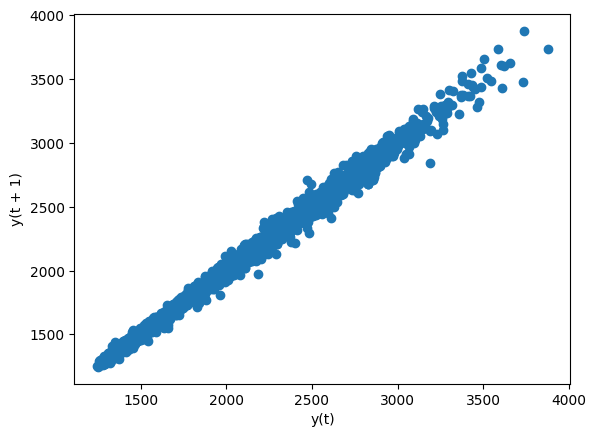

ZINC


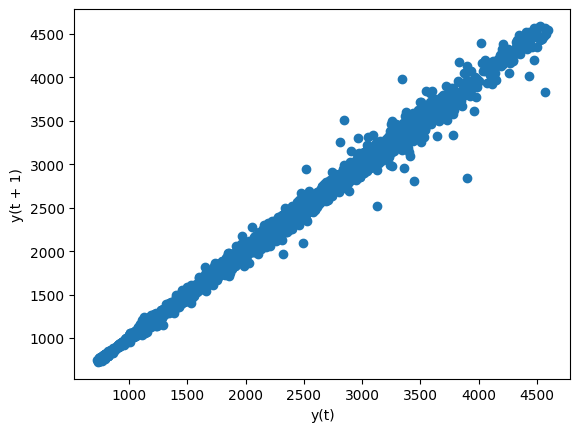

NICKEL


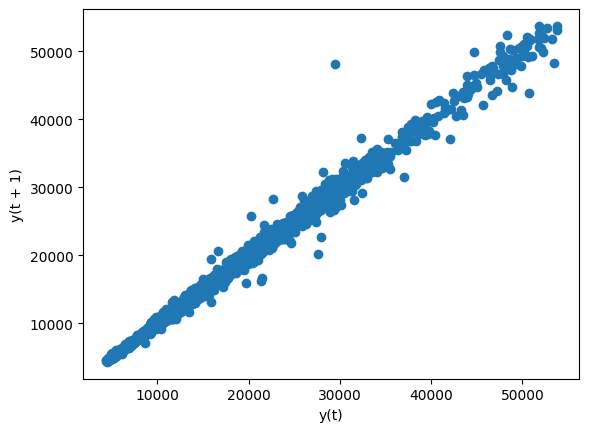

WHEAT


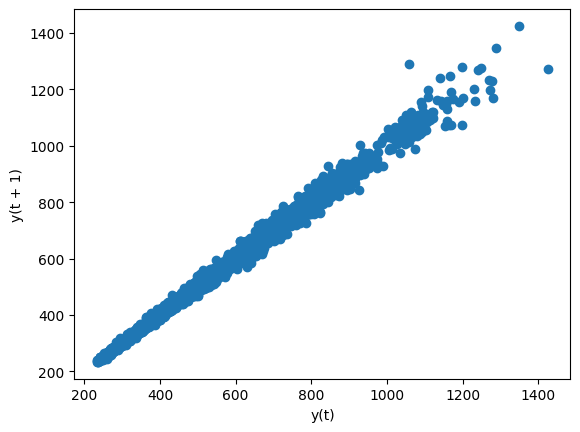

SUGAR


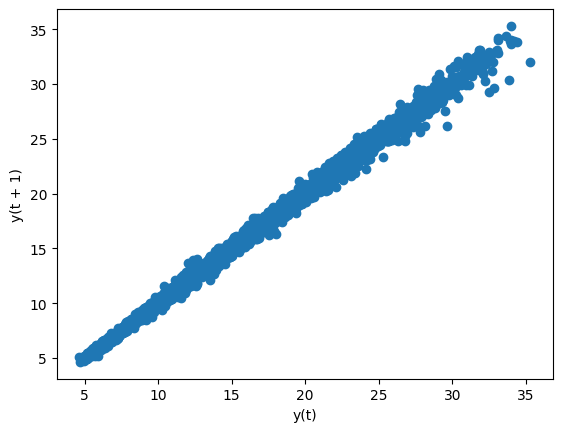

COFFEE


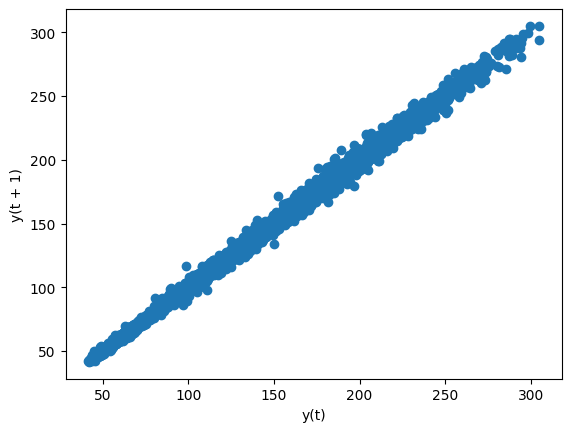

COTTON


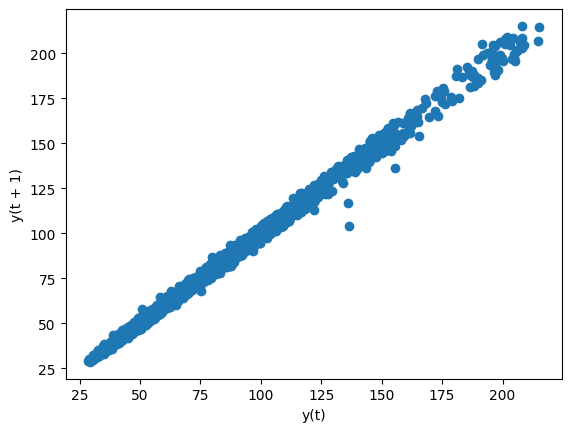

In [ ]:
for i in list:
  print(i)
  lag_plot(df1[i])
  plt.show()

#Con este lag_plot (función utilizada con mayor frecuencia para buscar patrones en datos de series de tiempo) intento hallar o identificar pautas y patrones que puedan especificar cada variable.
#La propensión de puntos sobre las diagonales de los gráficos indican que hay un proceso autoregresivo. Se observa poca dispersión de los puntos, más bien se centran sobre las diagonales.


In [ ]:
# Se calcula la matriz de correlación

corr = df1.corr()
corr

,GOLD,SOYBEANS,CORN,COPPER,SILVER,ALUMINIUM,ZINC,NICKEL,WHEAT,SUGAR,COFFEE,COTTON
GOLD,1.00,0.82,0.79,0.82,0.88,0.40,0.61,0.30,0.71,0.72,0.73,0.62
SOYBEANS,0.82,1.00,0.93,0.82,0.84,0.50,0.48,0.42,0.88,0.70,0.76,0.68
CORN,0.79,0.93,1.00,0.81,0.87,0.56,0.47,0.48,0.88,0.71,0.79,0.72
COPPER,0.82,0.82,0.81,1.00,0.85,0.79,0.80,0.68,0.81,0.74,0.79,0.68
SILVER,0.88,0.84,0.87,0.85,1.00,0.49,0.52,0.42,0.74,0.83,0.83,0.73
ALUMINIUM,0.40,0.50,0.56,0.79,0.49,1.00,0.77,0.82,0.64,0.44,0.60,0.52
ZINC,0.61,0.48,0.47,0.80,0.52,0.77,1.00,0.68,0.54,0.45,0.53,0.44
NICKEL,0.30,0.42,0.48,0.68,0.42,0.82,0.68,1.00,0.58,0.35,0.50,0.39
WHEAT,0.71,0.88,0.88,0.81,0.74,0.64,0.54,0.58,1.00,0.58,0.72,0.64
SUGAR,0.72,0.70,0.71,0.74,0.83,0.44,0.45,0.35,0.58,1.00,0.82,0.70


<Axes: >

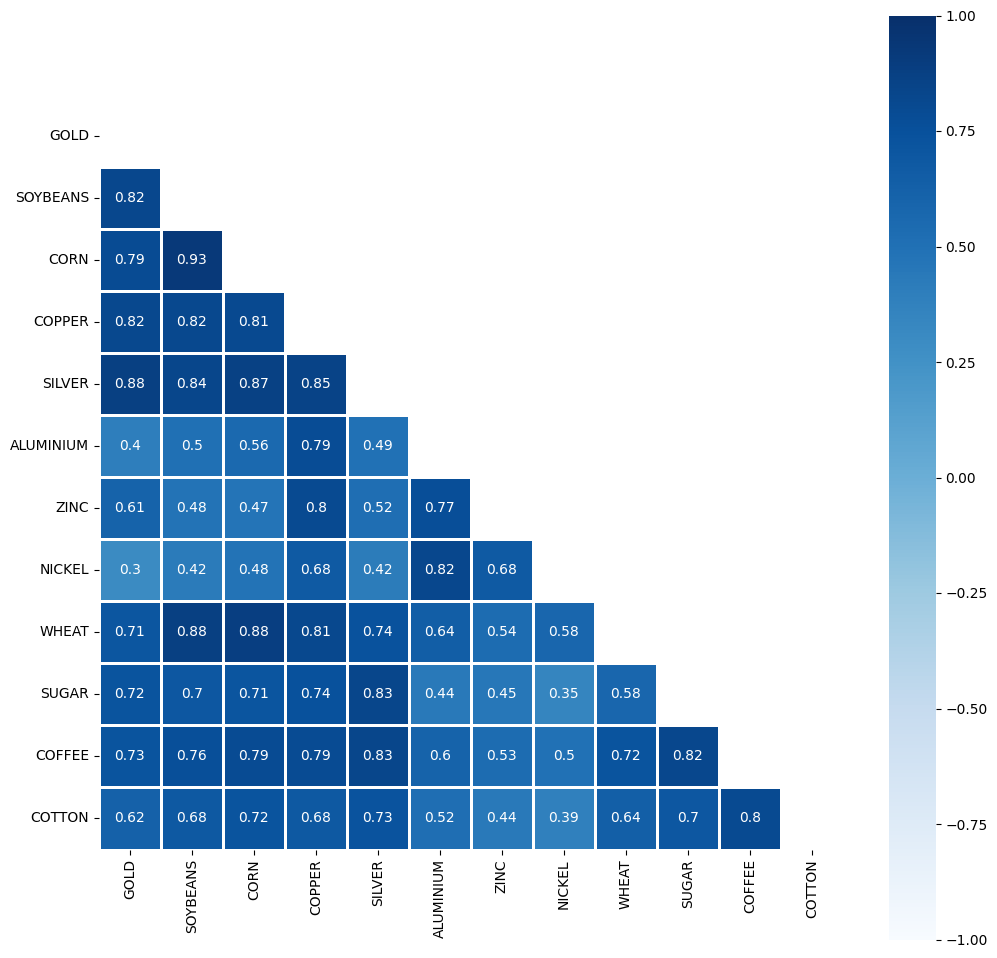

In [ ]:
# Para un mejor análisis realizo un mapa de calor sobre la matriz de correlación. Aquí se busca identificar como estan correlacionadas las variables:
# En color oscuro aquellas que tienen una mayor correlación
# En color más claro las que menor correlación aparentan
# Se observan correlaciones de todas las variables, algunas en mayor medida que otras. No hay coeficientes de correlación negativos.


# Generando la 'máscara' para realizar el triángulo
mask = np.triu(np.ones_like(corr, dtype = bool))

# Se configura el plot en cuanto al tamaño
f, ax= plt.subplots(figsize = (12,12))

#Se dibuja el 'heatmap' con su correspondiente máscara
sns.heatmap(corr, mask = mask, cmap = 'Blues', vmax=1, vmin=-1, center = 0, square= True, linewidths=2 ,annot=True )

# Dividir la serie en conjuntos de entrenamiento y prueba

El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las próximas 15 observaciones. Estos pronósticos se compararán con los datos reales del conjunto de prueba.<br>
He elegido un pequeño número de observaciones para guardar y compararlas luego, debido a que estos modelos de series temporales multivariantes son muy complejos. He realizado una prueba previamente escogiendo la regla implicita del 80% (datos entrenamiento) y 20% (datos de prueba), lo resultados no han sido favorables, el modelo no ha sido preciso.<br>
Cuanto más datos se le pase en X_test menos datos de entrenamiento, se traduce en una menor capacidad predictiva. No es un modelo capaz de acertar hacia un futuro muy lejano.<br>
Por ello he seleccionado solo 15 períodos hacia el futuro.

In [ ]:
n_obs = 15
X_train, X_test = df1[0:-n_obs], df1[-n_obs:]
print(X_train.shape, X_test.shape)


(6140, 12) (15, 12)


#Prueba de estacionariedad

Es preciso que los datos sean estacionarios para poder usar el modelo VAR. Lo averiguaré aplicando un Test de Dickey-Fuller aumentado a cada variable univariante que tiene el dataset.<br>
A continuación llevo a cabo un proceso iterativo de ir comparando estacionariedad con el Test mencionado.

In [ ]:


def test_dickey_fuller(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
print('Serie de tiempo: Precio del Oro')
test_dickey_fuller(X_train['GOLD'])
print('Serie de tiempo: Precio de la Plata')
test_dickey_fuller(X_train['SILVER'])
print('Serie de tiempo: Precio de la soja')
test_dickey_fuller(X_train['SOYBEANS'])
print('Serie de tiempo: Precio del maíz')
test_dickey_fuller(X_train['CORN'])
print('Serie de tiempo: Precio del cobre')
test_dickey_fuller(X_train['COPPER'])
print('Serie de tiempo: Precio del aluminio')
test_dickey_fuller(X_train['ALUMINIUM'])
print('Serie de tiempo: Precio del zinc')
test_dickey_fuller(X_train['ZINC'])
print('Serie de tiempo: Precio del niquel')
test_dickey_fuller(X_train['NICKEL'])
print('Serie de tiempo: Precio del trigo')
test_dickey_fuller(X_train['WHEAT'])
print('Serie de tiempo: Precio del azucar')
test_dickey_fuller(X_train['SUGAR'])
print('Serie de tiempo: Precio del café')
test_dickey_fuller(X_train['COFFEE'])
print('Serie de tiempo: Precio del algodón')
test_dickey_fuller(X_train['COTTON'])

Test de Dickey-Fuller Aumentado:
Serie de tiempo: Precio del Oro
p-value: 0.882372
Serie de tiempo: Precio de la Plata
p-value: 0.458334
Serie de tiempo: Precio de la soja
p-value: 0.384089
Serie de tiempo: Precio del maíz
p-value: 0.320909
Serie de tiempo: Precio del cobre
p-value: 0.374314
Serie de tiempo: Precio del aluminio
p-value: 0.114418
Serie de tiempo: Precio del zinc
p-value: 0.257979
Serie de tiempo: Precio del niquel
p-value: 0.121533
Serie de tiempo: Precio del trigo
p-value: 0.096153
Serie de tiempo: Precio del azucar
p-value: 0.109197
Serie de tiempo: Precio del café
p-value: 0.376246
Serie de tiempo: Precio del algodón
p-value: 0.068004


Lo que hago es comparar el p-valor obtenido con un nivel de significación que normalmente es de 0.05, lo que se traduce en un 95% de confianza.<br>
El test de Dickey-Fuller aumentado es un contraste de hipótesis: donde la hipótesis nula implica que la serie no es estacionaria, mientras que la hipótesis alternativa establece que sí es estacionaria la serie.<br>
Todos los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

# Transformación de la serie de entrenamiento

La aplicación de la diferenciación en el conjunto de entrenamiento debería lograr que las 12 variables sean estacionarias. Sin embargo, este es un proceso iterativo en el que, después de la primera diferenciación, es posible que la serie siga siendo no estacionaria. En tal caso debería aplicar una segunda diferenciación o transformación logarítmica para estandarizar la serie.<br>
Para diferenciarlos utilizaré la función 'diff()'

In [ ]:
#EL dropna() lo que hará es quitarme la primer fila ya esta tendrá datos faltantes

X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,GOLD,SOYBEANS,CORN,COPPER,SILVER,ALUMINIUM,ZINC,NICKEL,WHEAT,SUGAR,COFFEE,COTTON
Date,,,,,,,,,,,,
2000-01-04,0.00,7.75,2.25,0.00,0.00,0.00,-22.50,-132.00,-0.25,-0.33,-0.25,-0.34
2000-01-05,-1.60,5.00,0.00,0.01,-0.17,19.00,-5.75,-7.00,2.50,0.04,2.35,0.83
2000-01-06,0.30,-1.25,0.75,-0.00,-0.04,3.25,2.75,-55.00,-1.25,-0.04,-1.75,0.52
2000-01-07,0.50,3.50,3.25,0.00,0.03,12.25,-2.75,-78.00,3.25,0.07,-2.70,1.88
2000-01-10,-0.20,-5.25,1.50,-0.01,-0.00,-15.25,-12.50,-44.00,1.75,-0.01,3.40,-0.40


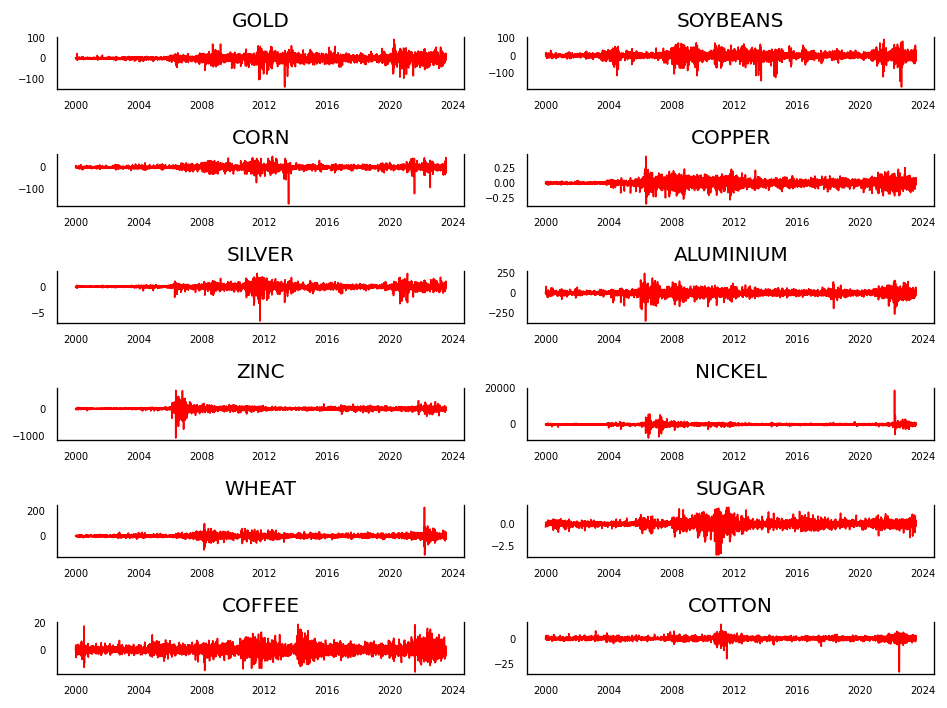

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(8,6))
for i, ax in enumerate(axes.flatten()):
  d = X_train_transformed[X_train_transformed.columns[i]]
  ax.plot(d, color='red', linewidth=1)
  ax.set_title(df1.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines['top'].set_alpha(0)
  ax.tick_params(labelsize=6)
  plt.tight_layout();


#Aquí se observa como lucen los datos transformados:
#A simple vista, ahora parecen estacionarios si los comparo con los gráficos anteriores (antes de realizar la diferenciación)

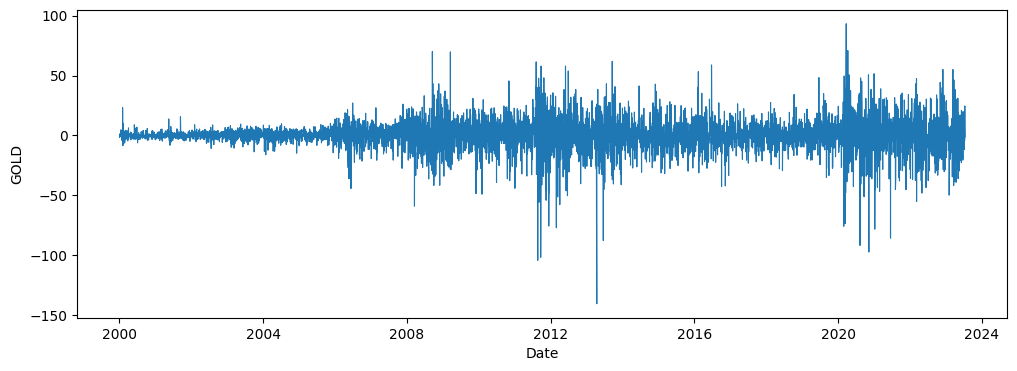

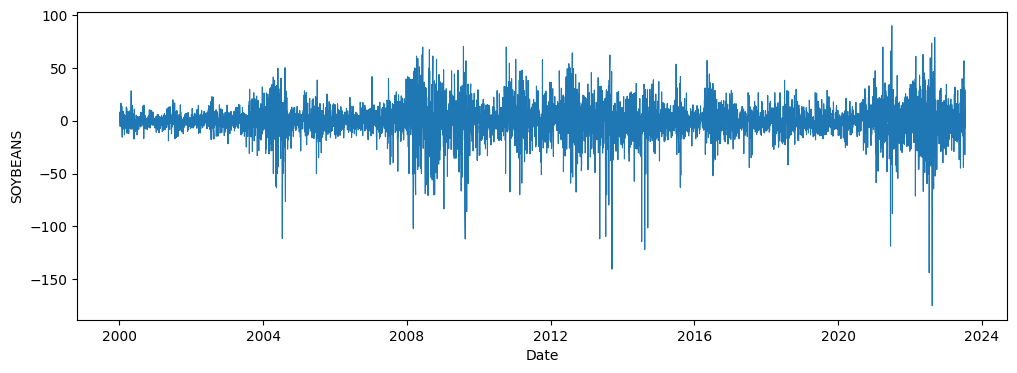

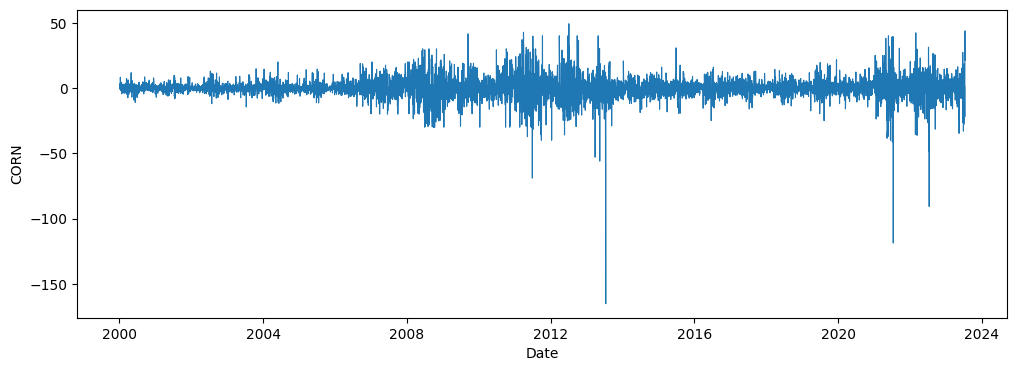

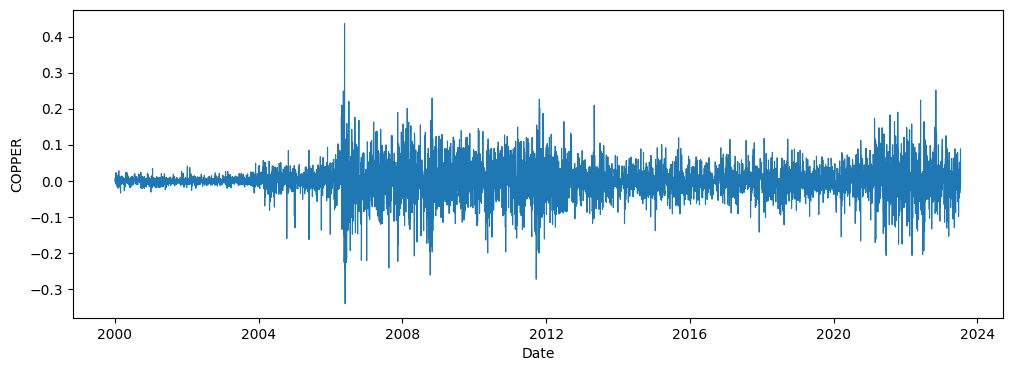

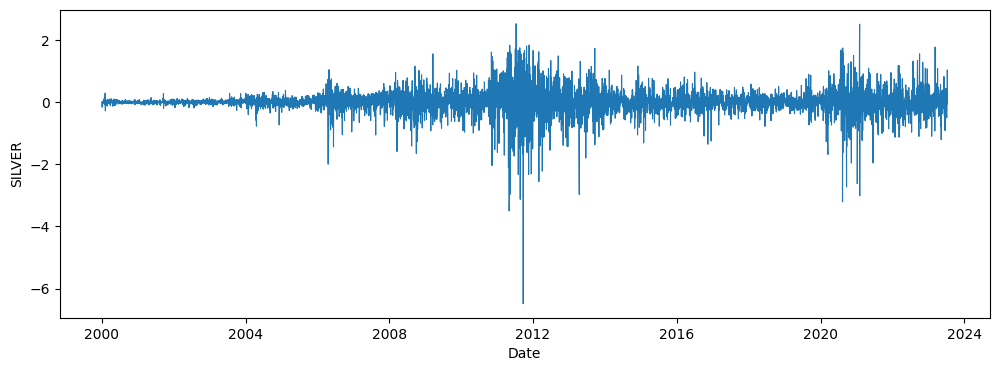

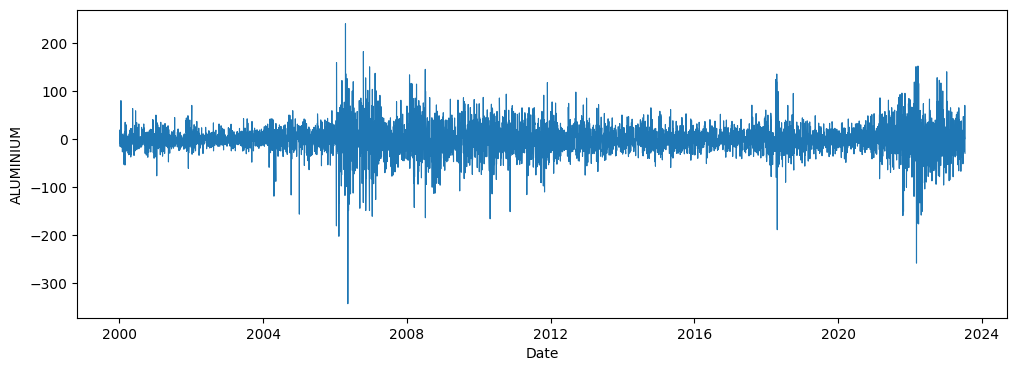

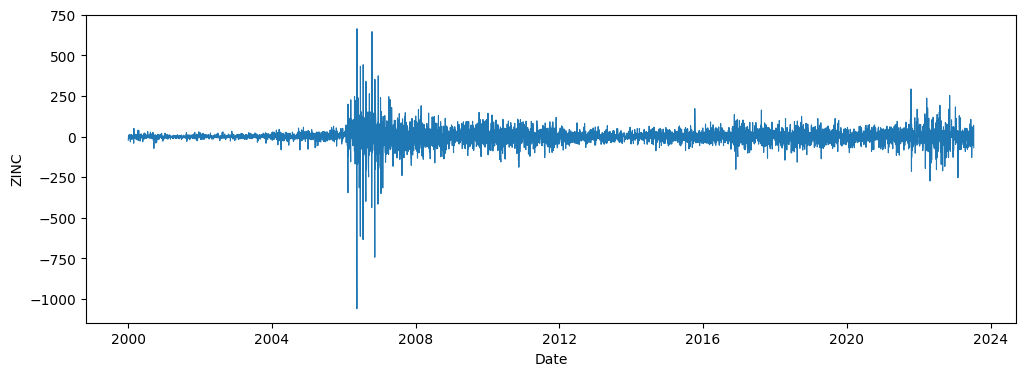

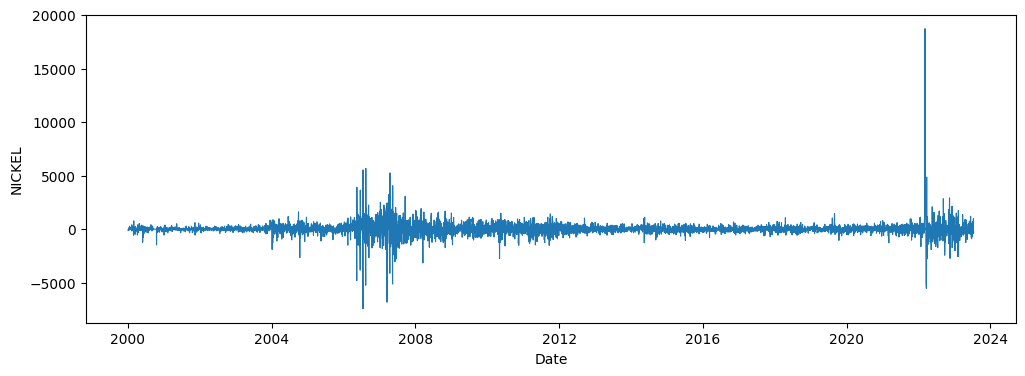

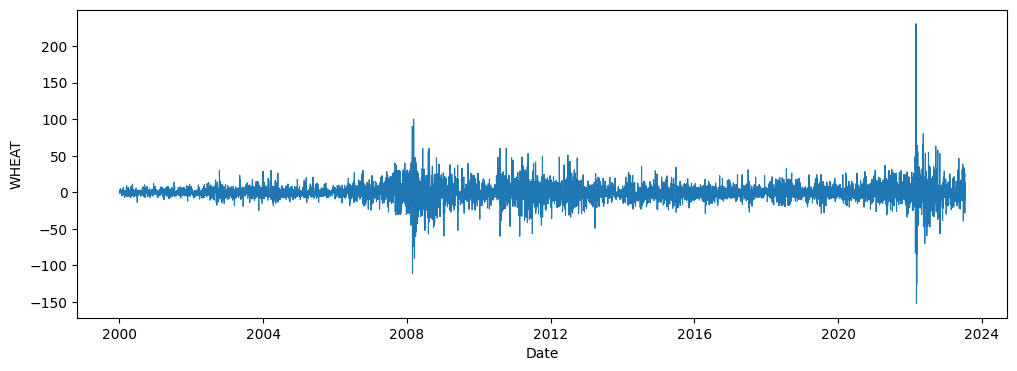

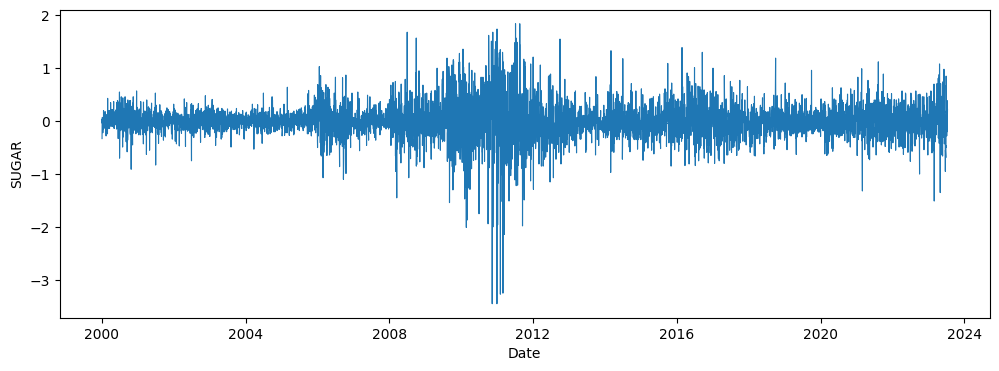

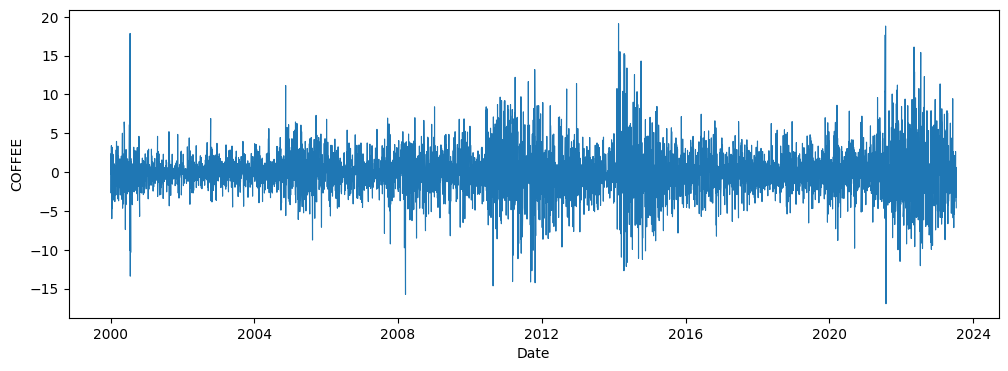

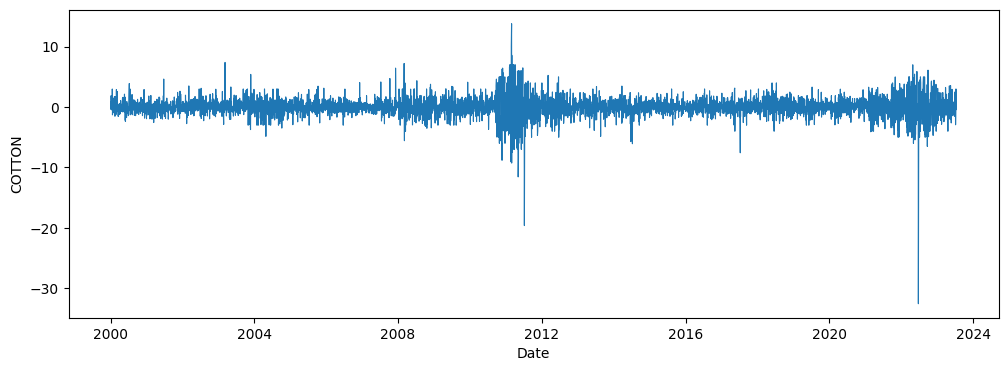

In [ ]:
#Gráficos más detallados
#Los picos que se observan pueden generar dudas de si se cumple o no la estacionariedad

for i in list:
  fig, ax = plt.subplots(figsize = (12,4))
  sns.lineplot(data = X_train_transformed, y= i, x= 'Date', linewidth= .8)
  plt.show()

Le vuelvo a aplicar el test de Dickey Fuller pero con los datos transformados (diferenciados):

In [ ]:
print('Test de Dickey-Fuller Aumentado:')
print('Serie de tiempo: Precio del Oro')
test_dickey_fuller(X_train_transformed['GOLD'])
print('Serie de tiempo: Precio de la Plata')
test_dickey_fuller(X_train_transformed['SILVER'])
print('Serie de tiempo: Precio de la soja')
test_dickey_fuller(X_train_transformed['SOYBEANS'])
print('Serie de tiempo: Precio del maíz')
test_dickey_fuller(X_train_transformed['CORN'])
print('Serie de tiempo: Precio del cobre')
test_dickey_fuller(X_train_transformed['COPPER'])
print('Serie de tiempo: Precio del aluminio')
test_dickey_fuller(X_train_transformed['ALUMINIUM'])
print('Serie de tiempo: Precio del zinc')
test_dickey_fuller(X_train_transformed['ZINC'])
print('Serie de tiempo: Precio del niquel')
test_dickey_fuller(X_train_transformed['NICKEL'])
print('Serie de tiempo: Precio del trigo')
test_dickey_fuller(X_train_transformed['WHEAT'])
print('Serie de tiempo: Precio del azucar')
test_dickey_fuller(X_train_transformed['SUGAR'])
print('Serie de tiempo: Precio del café')
test_dickey_fuller(X_train_transformed['COFFEE'])
print('Serie de tiempo: Precio del algodón')
test_dickey_fuller(X_train_transformed['COTTON'])

Test de Dickey-Fuller Aumentado:
Serie de tiempo: Precio del Oro
p-value: 0.000000
Serie de tiempo: Precio de la Plata
p-value: 0.000000
Serie de tiempo: Precio de la soja
p-value: 0.000000
Serie de tiempo: Precio del maíz
p-value: 0.000000
Serie de tiempo: Precio del cobre
p-value: 0.000000
Serie de tiempo: Precio del aluminio
p-value: 0.000000
Serie de tiempo: Precio del zinc
p-value: 0.000000
Serie de tiempo: Precio del niquel
p-value: 0.000000
Serie de tiempo: Precio del trigo
p-value: 0.000000
Serie de tiempo: Precio del azucar
p-value: 0.000000
Serie de tiempo: Precio del café
p-value: 0.000000
Serie de tiempo: Precio del algodón
p-value: 0.000000


Todos los p-valores son menores que 0.05 por lo tanto se podría concluir que con un solo orden de diferenciación se obtienen series estacionarias.

# Construcción de un modelo VAR sobre las series transformadas

El VAR requiere la estacionariedad de la serie, lo que significa que la media de la serie no cambia con el tiempo (lo cual se observa en el gráfico dibujado junto a la Prueba de Dickey-Fuller aumentada).

In [ ]:
model = VAR(X_train_transformed)

## Seleccionando el orden del modelo

In [ ]:
# Con 'select_order()' lo que busco es establecer cual es el orden que debería tener el modelo.
# Normalmente se establece un máximo de 10 o de 15 como en este caso
# Tal como se observa exiten distintos criterios: AIC, BIC, FPE, HQIC
# Voy a trabajar con el criterio AIC. Entonces observo donde se encuentra el asterisco(*), el cual me establece el orden a seleccionar.
# En este caso, según el criterio AIC debo seleccionar el orden 8

modelsel=model.select_order(15)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,37.23,37.25*,1.481e+16,37.24
1,37.12,37.29,1.317e+16,37.18*
2,37.09,37.42,1.286e+16,37.21
3,37.08,37.57,1.271e+16,37.25
4,37.09,37.73,1.277e+16,37.31
5,37.09,37.89,1.282e+16,37.37
6,37.09,38.05,1.282e+16,37.42
7,37.08,38.20,1.264e+16,37.46
8,37.07*,38.35,1.261e+16*,37.52
9,37.07,38.51,1.262e+16,37.57


## Ajuste del modelo

In [ ]:
res = model.fit(maxlags=8, ic='aic')   #Establezco el orden y el criterio
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Sep, 2024
Time:                     14:00:29
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    38.3409
Nobs:                     6131.00    HQIC:                   37.5075
Log likelihood:          -216853.    FPE:                1.25053e+16
AIC:                      37.0649    Det(Omega_mle):     1.03583e+16
--------------------------------------------------------------------
Results for equation GOLD
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.291833         0.161685            1.805           0.071
L1.GOLD             -0.024529         0.019960           -1.229           0.219
L1.SOYBEANS          0.005868         0.012075            0.486  

# Causalidad de Granger

Aplicaré el test de la Causalidad de Granger, el cual está basado en un contraste de hipótesis. Donde H0 es que la variable en cuestión que estoy estudiando no se cree que cause a las demás variables, mientras que H1 establece lo contrario.<br>
Si el p-valor es menor que 0.05: Rechazo la hipótesis nula H0 y mantengo la variable dentro del modelo.<br>
En caso de obtener un p-valor mayor de 0.05 puedo plantear la idea de eliminar dicha variable del modelo, esto es opcional, hay que llevar a cabo comprobaciones y decidir en base a ello. No hay nada establecido al respecto, solo distintos caminos a tener en cuenta.

A continuación utilizando 'test_causality' enfrentaré a cada una de las variables con todas las demás y observaré el <u>p-valor</u> de cada una.

### GOLD

In [ ]:
grangercaus=res.test_causality(['SOYBEANS', 'CORN','COPPER','SILVER','ALUMINIUM',
      'ZINC', 'NICKEL', 'WHEAT', 'SUGAR', 'COFFEE', 'COTTON' ],['GOLD'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.819,1.260,0.000,"(88, 72408)"


### SOYBEANS

In [ ]:

grangercaus=res.test_causality(['GOLD','CORN','COPPER','SILVER','ALUMINIUM',
'ZINC', 'NICKEL', 'WHEAT', 'SUGAR', 'COFFEE', 'COTTON' ],['SOYBEANS'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.235,1.260,0.067,"(88, 72408)"


### CORN

In [ ]:

grangercaus=res.test_causality(['GOLD','SOYBEANS','COPPER','SILVER','ALUMINIUM',
'ZINC', 'NICKEL', 'WHEAT', 'SUGAR', 'COFFEE', 'COTTON' ],['CORN'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.064,1.260,0.000,"(88, 72408)"


### COPPER

In [ ]:

grangercaus=res.test_causality(['GOLD','SOYBEANS','CORN','SILVER','ALUMINIUM',
'ZINC', 'NICKEL', 'WHEAT', 'SUGAR', 'COFFEE', 'COTTON' ],['COPPER'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.407,1.260,0.000,"(88, 72408)"


### SILVER

In [ ]:

grangercaus=res.test_causality(['GOLD','SOYBEANS','CORN','COPPER','ALUMINIUM',
'ZINC', 'NICKEL', 'WHEAT', 'SUGAR', 'COFFEE', 'COTTON' ],['SILVER'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.646,1.260,0.000,"(88, 72408)"


### ALUMINIUM

In [ ]:

grangercaus=res.test_causality(['GOLD','SOYBEANS','CORN','COPPER','SILVER','ZINC',
'NICKEL', 'WHEAT', 'SUGAR', 'COFFEE', 'COTTON' ],['ALUMINIUM'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.529,1.260,0.000,"(88, 72408)"


### ZINC

In [ ]:

grangercaus=res.test_causality(['GOLD','SOYBEANS','CORN','COPPER','SILVER','ALUMINIUM',
'NICKEL', 'WHEAT', 'SUGAR', 'COFFEE', 'COTTON' ],['ZINC'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.233,1.260,0.000,"(88, 72408)"


### NICKEL

In [ ]:

grangercaus=res.test_causality(['GOLD','SOYBEANS','CORN','COPPER','SILVER','ALUMINIUM',
'ZINC', 'WHEAT', 'SUGAR', 'COFFEE', 'COTTON' ],['NICKEL'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
3.740,1.260,0.000,"(88, 72408)"


### WHEAT

In [ ]:

grangercaus=res.test_causality(['GOLD','SOYBEANS','CORN','COPPER','SILVER','ALUMINIUM',
'ZINC', 'NICKEL', 'SUGAR', 'COFFEE', 'COTTON' ],['WHEAT'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
4.788,1.260,0.000,"(88, 72408)"


### SUGAR

In [ ]:

grangercaus=res.test_causality(['GOLD','SOYBEANS','CORN','COPPER','SILVER','ALUMINIUM',
'ZINC', 'NICKEL', 'WHEAT', 'COFFEE', 'COTTON' ],['SUGAR'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.714,1.260,0.000,"(88, 72408)"


### COFFEE

In [ ]:

grangercaus=res.test_causality(['GOLD','SOYBEANS','CORN','COPPER','SILVER','ALUMINIUM',
'ZINC', 'NICKEL', 'WHEAT', 'SUGAR', 'COTTON' ],['COFFEE'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.580,1.260,0.000,"(88, 72408)"


### COTTON

In [ ]:

grangercaus=res.test_causality(['GOLD','SOYBEANS','CORN','COPPER','SILVER','ALUMINIUM',
'ZINC', 'NICKEL', 'WHEAT', 'SUGAR', 'COFFEE' ],['COTTON'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.533,1.260,0.000,"(88, 72408)"


Los resultados son favorables, cada una de las variables con un p-valor pequeño (< 0.05), <u>a exepción de la variable 'SOYBEANS'</u>.<br>
A continuación, establezco una matriz en la cual será posible observar con claridad la estimación de los p-valores de cada una de las variables con las demás. Si nos centramos en la fila de 'SOYBEANS' (la variable problemática) se verá que no causa a: 'SILVER', 'ALUMINIUM', 'ZINC', 'NICKEL' Y 'COFFEE'. A algunas de estas variables no las causa por muy poco: 'ALUMINIUM', 'ZINC' tienen un valor de 0.05.<br>
 Con la información que aporta dicha matriz decido que no es conveniente eliminar la variable 'SOYBEANS', continuaré con todas mis variables.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

maxlag=8
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [(test_result[i+1][0][test][1]) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)


,GOLD_x,SOYBEANS_x,CORN_x,COPPER_x,SILVER_x,ALUMINIUM_x,ZINC_x,NICKEL_x,WHEAT_x,SUGAR_x,COFFEE_x,COTTON_x
GOLD_y,1.00,0.05,0.07,0.20,0.01,0.44,0.33,0.01,0.00,0.01,0.01,0.51
SOYBEANS_y,0.01,1.00,0.00,0.01,0.06,0.05,0.05,0.21,0.00,0.02,0.14,0.03
CORN_y,0.01,0.08,1.00,0.03,0.20,0.03,0.49,0.02,0.00,0.07,0.03,0.00
COPPER_y,0.38,0.03,0.14,1.00,0.15,0.33,0.00,0.00,0.00,0.01,0.32,0.13
SILVER_y,0.00,0.00,0.00,0.05,1.00,0.49,0.28,0.00,0.00,0.00,0.00,0.01
ALUMINIUM_y,0.02,0.00,0.08,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.08,0.08
ZINC_y,0.00,0.00,0.07,0.00,0.00,0.00,1.00,0.00,0.00,0.05,0.01,0.01
NICKEL_y,0.00,0.00,0.00,0.02,0.01,0.00,0.00,1.00,0.00,0.09,0.27,0.00
WHEAT_y,0.03,0.39,0.00,0.17,0.05,0.13,0.23,0.00,1.00,0.10,0.00,0.00
SUGAR_y,0.15,0.00,0.08,0.32,0.01,0.64,0.31,0.53,0.28,1.00,0.11,0.00


# Diagnosis del modelo

Para llevar a cabo la diagnosis del modelo lo principal es estudiar los residuos del mismo

## Residuos

In [ ]:
# res es mi modelo ajustado
residuals=res.resid

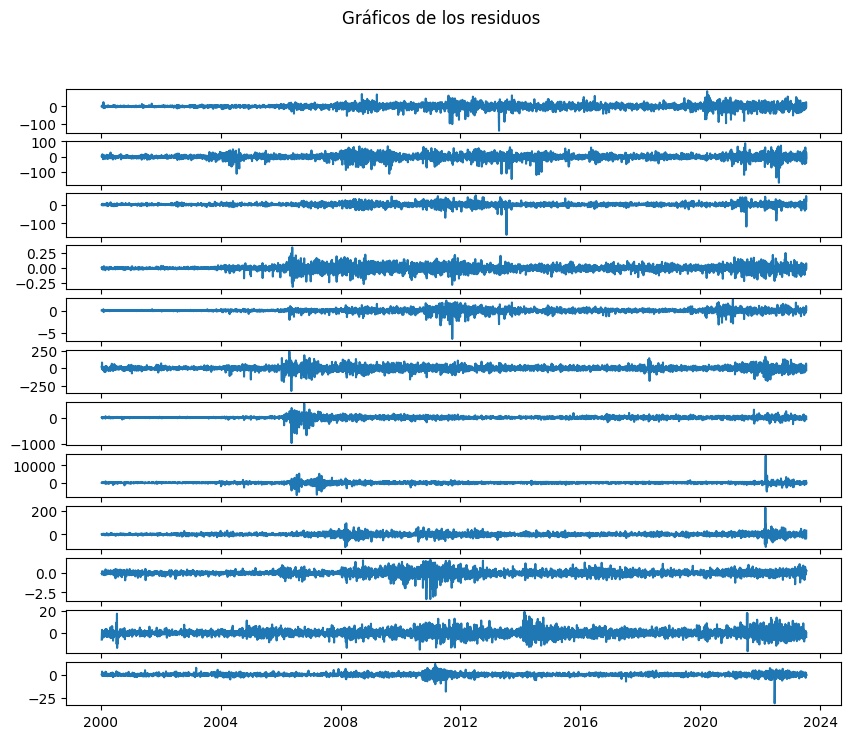

In [ ]:
# Con el gráfico de los residuos voy a comprobar si estos son RUIDO BLANCO. Osea si presentan autocorrelaciones, si la media es constante,
# si la varianza es constante, observar como lucen estos gráficos y luego aplicarles el test de Dickey-Fuller para saber si son estacionarios.
# Como tengo 12 variables voy a obtener 12 gráficos con series temporales de residuos, un gráfico por cada variable
# Se puede observar ruido blanco en la mayoria de los gráficos a expción de algunos picos



fig, axs = plt.subplots(12)
fig.suptitle('Gráficos de los residuos',fontsize=12)
fig.set_size_inches(10,8)
[axs[i].plot(residuals.iloc[:,i]) for i in range(12)]
plt.show()




## Test de Dickey - Fuller aplicado a los Residuos





In [ ]:
print('Test Dickey - Fuller de los residuos, p-valores: ')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(12)]

Test Dickey - Fuller de los residuos, p-valores: 


[0.0,
 0.0,
 6.555515107402699e-26,
 0.0,
 2.3246244494513676e-28,
 2.119368888023416e-23,
 1.3788948724118572e-28,
 1.396750869604825e-28,
 3.427371441108473e-30,
 2.7936215061367385e-22,
 0.0,
 0.0]

Todos los p-valores son menores de 0.05, por lo tanto se rechaza la hipótesis nula de que las 12 series de residuos no son estacionarias. Con un 95% de confianza se cree que son estacionarias.

## ACF de los Residuos

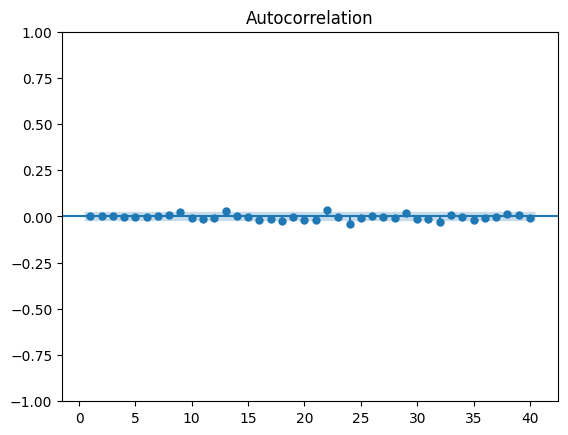

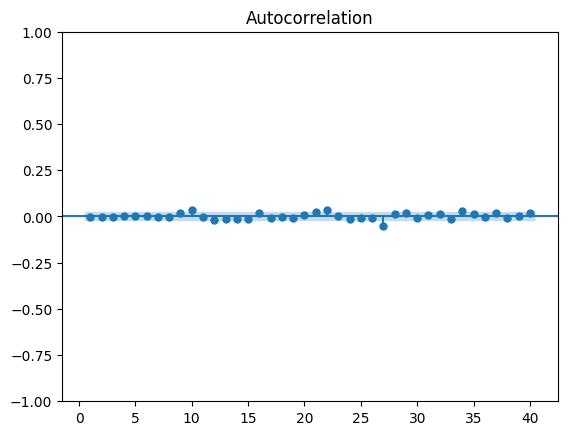

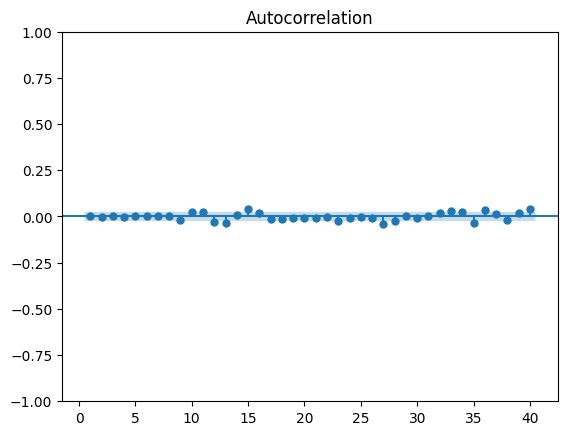

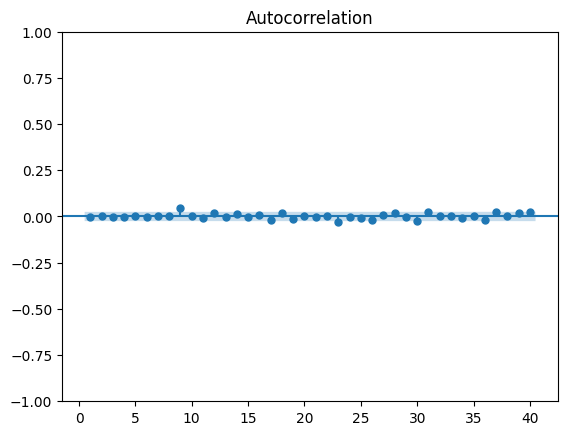

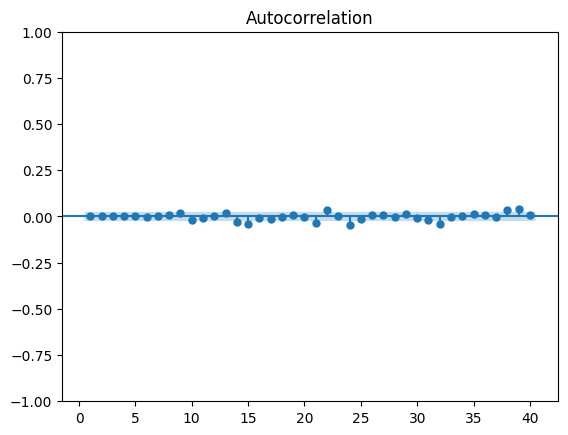

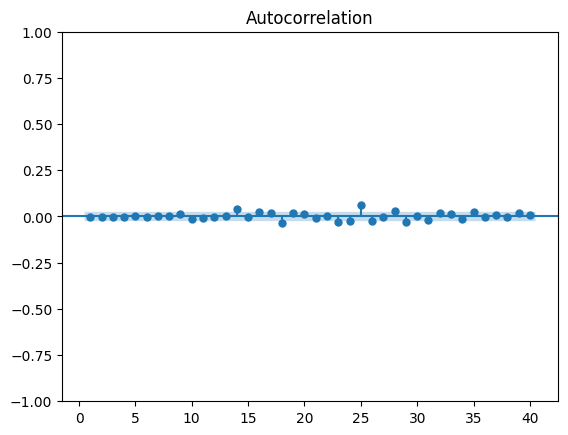

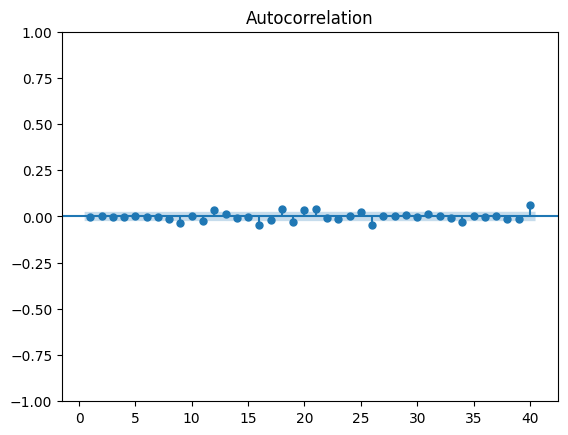

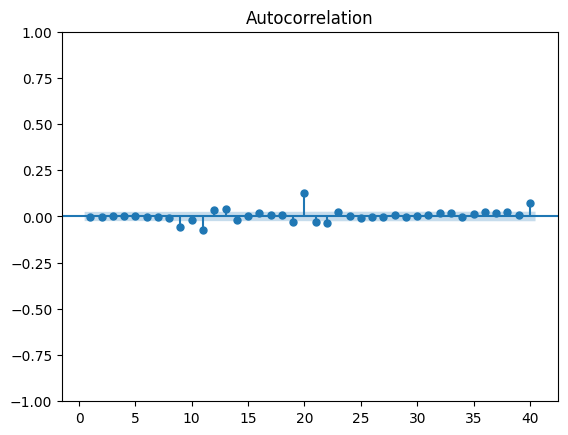

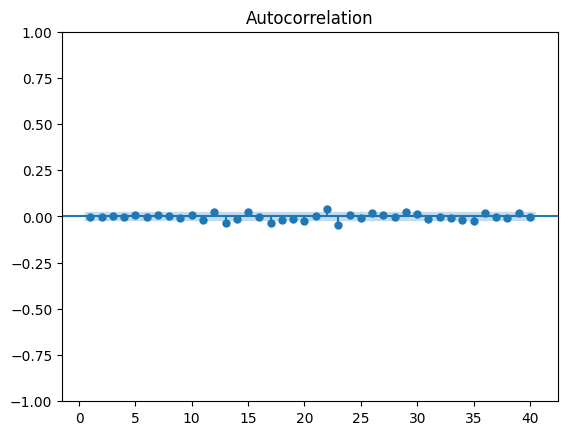

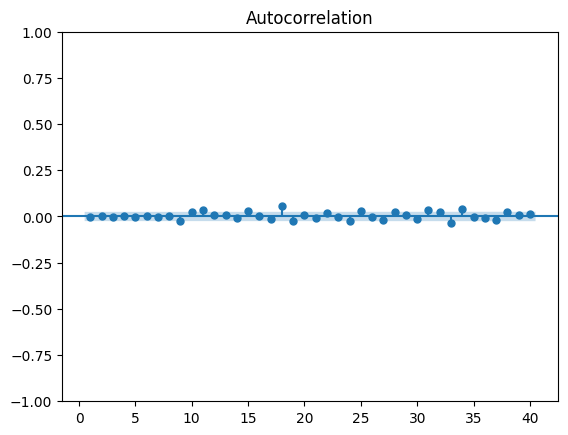

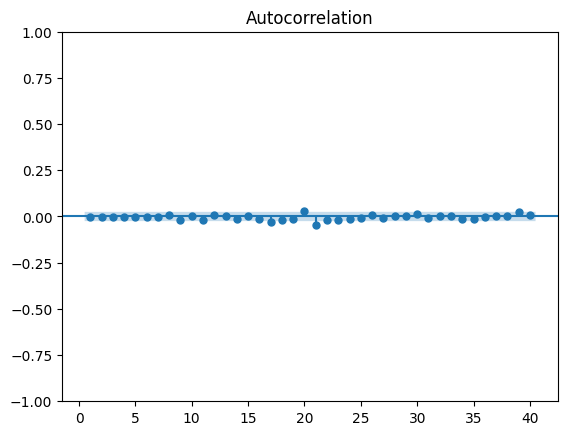

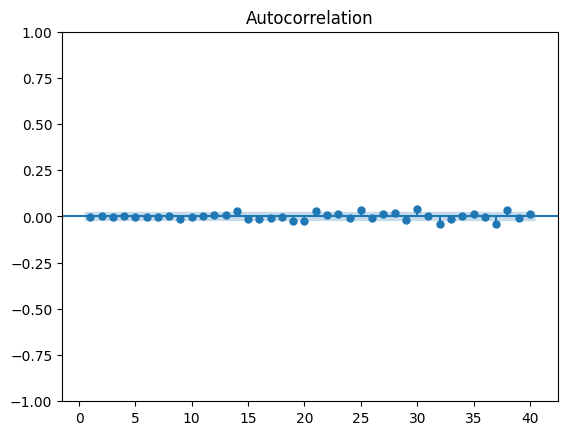

In [ ]:
# Se dibujan las funciones de autocorrelación para cada una de las series
# En todos los gráficos predominan los valores dentro del area sombreada, por lo tanto son valores muy cercanos a ser igual a 0,
# autocorrelación significativamente igual a 0 significa que no hay autocorrelación.
# Son pocos los puntos que sobresalen del area sombreada y tienen un valor muy pequeño, alejado de 0.05. Por lo tanto no me preocupo

[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 40) for i in range(12)]
plt.show()


<u>Conclusión:</u> Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco, tal como es deseable.

## Valores predichos

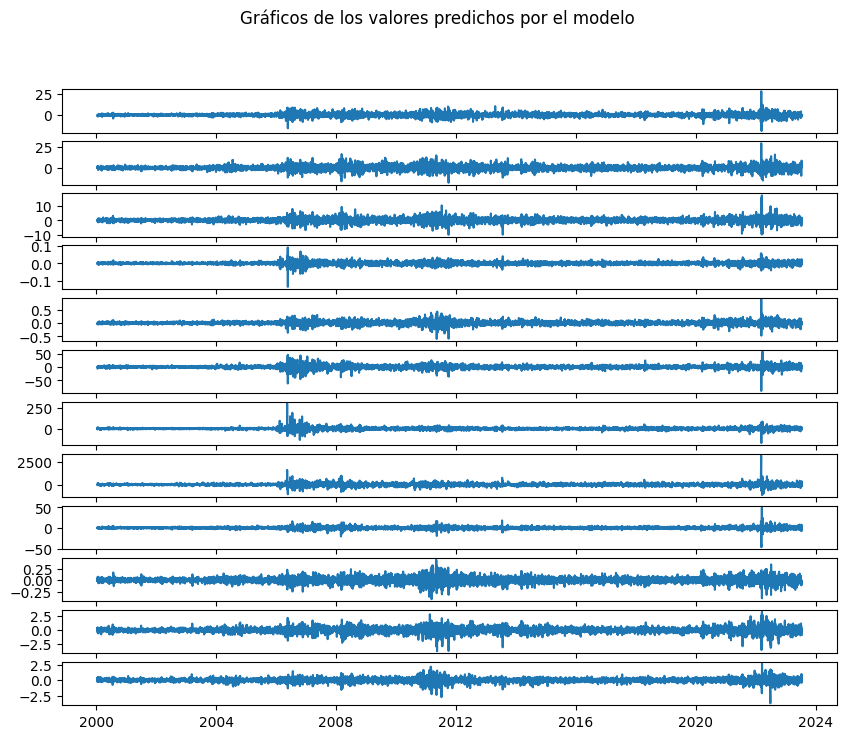

In [ ]:

y_fit = res.fittedvalues                                                          # Se guardan los valores predichos
fig, axs = plt.subplots(12)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=12)
fig.set_size_inches(10,8)
[axs[i].plot(y_fit.iloc[:,i]) for i in range(12)]
plt.show()


Hay que tener en cuenta, más allá de los resultados que arrojen estos gráficos, que no son los precios reales como tenía al comienzo.  <u>Estos son transformaciones de precios.</u> Cuando intente obtener los pronósticos de cara al futuro no los podré interpretar, habrá que deshacer la transformación de diferenciación que se hizo anteriormente.<br>
Esto mismo se hará a continuación.

# PRONÓSTICOS

## Hallando los pronósticos

Le paso al modelo VAR el número de orden de retraso de observaciones de los datos pasados, ya que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos. Por lo tanto se le debe proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaría introduciendo poca credibilidad.

In [ ]:

# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)

# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]                                # Me va a predecir los últimos 15 datos
# Forecasting
pred = res.forecast(y=input_data, steps=n_obs)                                      # con 'steps' establezco cuantos períodos futuros quiero pronosticar a partir del último período de los datos de entrada
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))   # Armo un df para poder comparar los datos reservados en X_test con las predicciones
print('Predicciones:')
pred

Orden del modelo: 8
Predicciones:


,GOLD_pred,SOYBEANS_pred,CORN_pred,COPPER_pred,SILVER_pred,ALUMINIUM_pred,ZINC_pred,NICKEL_pred,WHEAT_pred,SUGAR_pred,COFFEE_pred,COTTON_pred
Date,,,,,,,,,,,,
2023-07-17,-1.84,0.81,2.92,0.00,-0.04,11.06,12.27,-153.07,8.54,0.02,-0.55,0.03
2023-07-18,-5.09,-0.57,-0.77,-0.02,-0.06,-0.06,1.95,150.73,3.83,0.03,0.75,0.02
2023-07-19,2.58,5.59,-0.04,0.01,0.14,2.82,15.88,-23.16,-4.24,0.08,0.30,-0.38
2023-07-20,-2.14,-0.76,-0.42,0.00,-0.02,-0.65,5.15,192.51,2.89,-0.06,-0.89,0.21
2023-07-21,0.08,3.31,-0.42,0.00,0.04,3.57,-3.64,69.73,-1.50,-0.04,1.15,0.54
2023-07-24,3.41,5.87,2.26,-0.00,0.14,3.77,-6.96,-146.18,0.84,0.13,0.17,-0.11
2023-07-25,-1.50,0.01,-1.34,-0.00,-0.03,-0.73,2.70,-13.24,-2.27,-0.01,0.18,-0.31
2023-07-26,-1.43,-1.18,-0.72,-0.00,-0.01,2.57,3.20,14.40,-0.13,-0.04,-0.05,-0.19
2023-07-27,0.18,0.53,0.26,0.00,0.01,-0.60,-1.89,47.66,0.77,-0.00,0.14,0.06


<Figure size 1600x1400 with 0 Axes>

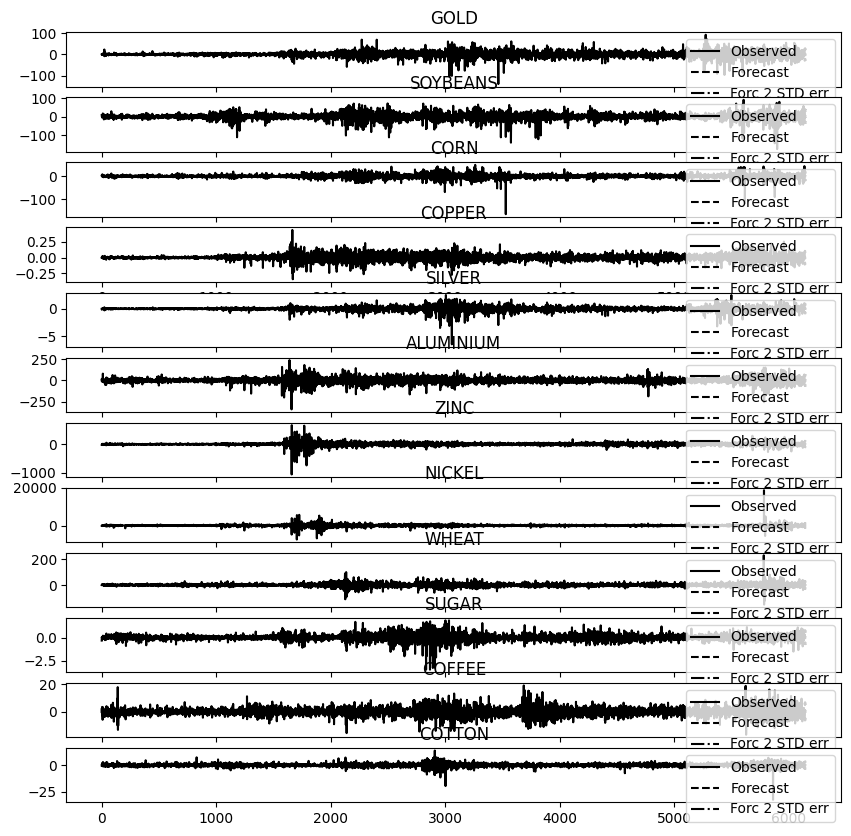

In [ ]:
plt.figure(figsize = (16,14))
res.plot_forecast(15)
#plt.tight_layout(h_pad = 0.25)
plt.show()

Como se ha mencionado anteriormente, lo que se obtiene son series estacionarias que no se pueden interpretar.

## Invirtiendo la transformación de los pronósticos a la escala original

Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, tengo que des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)

In [ ]:
# Invirtiendo la transformación

def invert_transformation(X_train, pred):
  forecast = pred.copy()
  columns = X_train.columns
  for col in columns:
    forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()    #sumas acumuladas
  return forecast

output = invert_transformation(X_train, pred)
output

,GOLD_pred,SOYBEANS_pred,CORN_pred,COPPER_pred,SILVER_pred,ALUMINIUM_pred,ZINC_pred,NICKEL_pred,WHEAT_pred,SUGAR_pred,COFFEE_pred,COTTON_pred
Date,,,,,,,,,,,,
2023-07-17,"1,960.66","1,512.31",617.67,3.92,24.87,"2,220.57","2,404.52","20,656.93",662.29,24.25,154.20,82.74
2023-07-18,"1,955.57","1,511.74",616.90,3.90,24.81,"2,220.51","2,406.48","20,807.66",666.12,24.28,154.95,82.76
2023-07-19,"1,958.15","1,517.32",616.87,3.92,24.95,"2,223.33","2,422.36","20,784.51",661.88,24.36,155.25,82.39
2023-07-20,"1,956.01","1,516.57",616.45,3.92,24.93,"2,222.68","2,427.51","20,977.01",664.76,24.30,154.36,82.60
2023-07-21,"1,956.09","1,519.88",616.03,3.92,24.97,"2,226.24","2,423.87","21,046.74",663.26,24.26,155.52,83.14
2023-07-24,"1,959.50","1,525.74",618.29,3.92,25.11,"2,230.02","2,416.90","20,900.55",664.10,24.38,155.69,83.03
2023-07-25,"1,957.99","1,525.75",616.95,3.92,25.09,"2,229.29","2,419.60","20,887.31",661.83,24.37,155.87,82.72
2023-07-26,"1,956.57","1,524.57",616.23,3.92,25.07,"2,231.86","2,422.80","20,901.71",661.70,24.34,155.82,82.53
2023-07-27,"1,956.75","1,525.11",616.49,3.92,25.08,"2,231.26","2,420.91","20,949.38",662.47,24.33,155.97,82.59


**Ahora si que tengo los datos en su escala original**

A continuación publicaré los valores predichos, seleccionando una variable de cada uno de los grupos:

*   Metales preciosos
*   Granos

*   Metales industriales
*   Softs






### Pronósticos del <u>oro</u>


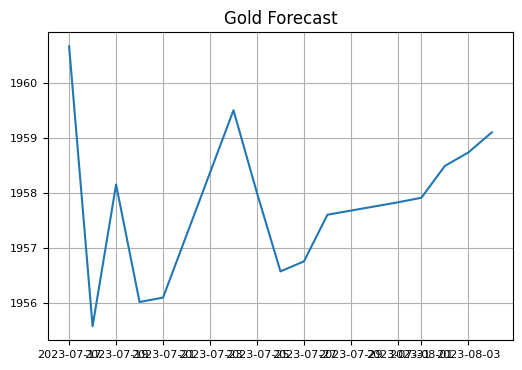

In [ ]:

plt.figure(figsize = (6,4))
plt.plot(output.iloc[:,0])
plt.tick_params(labelsize = 8)
plt.title('Gold Forecast')
plt.grid()
plt.show()

### Pronósticos de la <u>plata</u>

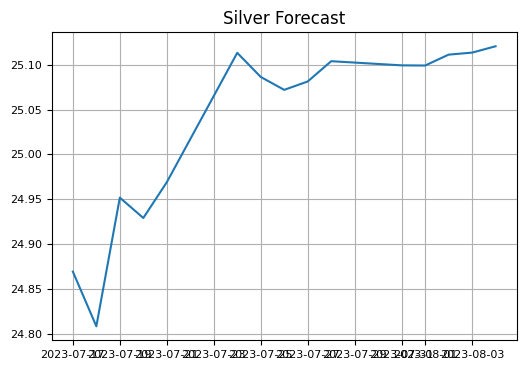

In [ ]:
plt.figure(figsize = (6,4))
plt.plot(output.iloc[:,4])
plt.tick_params(labelsize = 8)
plt.title('Silver Forecast')
plt.grid()
plt.show()

### Pronósticos del <u>cobre</u>

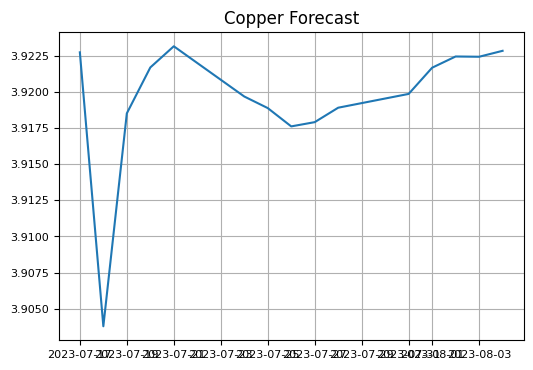

In [ ]:
plt.figure(figsize = (6,4))
plt.plot(output.iloc[:,3])
plt.tick_params(labelsize = 8)
plt.title('Copper Forecast')
plt.grid()
plt.show()

### Pronósticos de la <u>soja</u>
La variable 'SOYBEANS' la he seleccionado principalmente porque es la única que no ha pasado el Test de Causalidad de Granger. Se verá más adelante, durante la evaluación, que es la variable con las peores métricas.

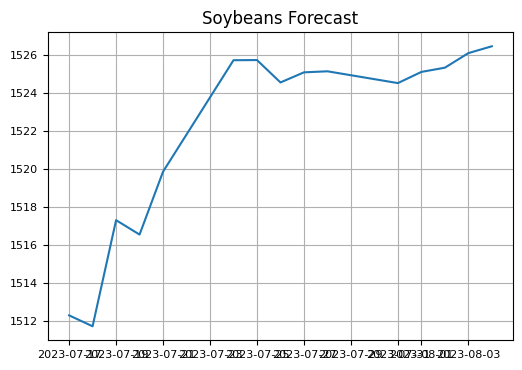

In [ ]:
plt.figure(figsize = (6,4))
plt.plot(output.iloc[:,1])
plt.tick_params(labelsize = 8)
plt.title('Soybeans Forecast')
plt.grid()
plt.show()

### Pronósticos del <u>azúcar</u>

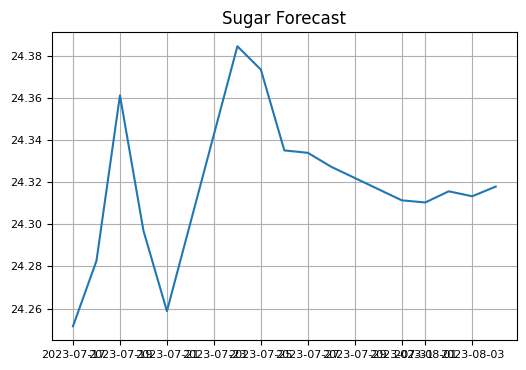

In [ ]:
plt.figure(figsize = (6,4))
plt.plot(output.iloc[:,9])
plt.tick_params(labelsize = 8)
plt.title('Sugar Forecast')
plt.grid()
plt.show()

A continuación comparo los datos pronosticados con los datos de prueba dentro de un mismo dataset. Se sabe de antemano que valores han tomado los precios de las variables en las fechas pronosticadas y se han reservado precisamente para ser comparadas con los valores predichos.



In [ ]:
#Oro

join_GOLD = pd.concat([output['GOLD_pred'], X_test['GOLD']], axis=1)
join_GOLD = join_GOLD.reset_index()
join_GOLD = join_GOLD.sort_values(by='Date', ascending=False)
join_GOLD

,Date,GOLD_pred,GOLD
14,2023-08-04,"1,959.09","1,939.00"
13,2023-08-03,"1,958.73","1,932.00"
12,2023-08-02,"1,958.48","1,937.40"
11,2023-08-01,"1,957.91","1,940.70"
10,2023-07-31,"1,957.82","1,970.50"
9,2023-07-28,"1,957.60","1,960.00"
8,2023-07-27,"1,956.75","1,945.70"
7,2023-07-26,"1,956.57","1,970.10"
6,2023-07-25,"1,957.99","1,963.70"
5,2023-07-24,"1,959.50","1,962.20"


In [ ]:
# Plata

join_SILVER = pd.concat([output['SILVER_pred'], X_test['SILVER']], axis=1)
join_SILVER = join_SILVER.reset_index()
join_SILVER = join_SILVER.sort_values(by='Date', ascending=False)
join_SILVER

,Date,SILVER_pred,SILVER
14,2023-08-04,25.12,23.68
13,2023-08-03,25.11,23.70
12,2023-08-02,25.11,23.87
11,2023-08-01,25.10,24.33
10,2023-07-31,25.10,24.97
9,2023-07-28,25.10,24.48
8,2023-07-27,25.08,24.24
7,2023-07-26,25.07,24.82
6,2023-07-25,25.09,24.68
5,2023-07-24,25.11,24.44


In [ ]:
#Cobre

join_COPPER = pd.concat([output['COPPER_pred'], X_test['COPPER']], axis=1)
join_COPPER = join_COPPER.reset_index()
join_COPPER = join_COPPER.sort_values(by='Date', ascending=False)
join_COPPER

,Date,COPPER_pred,COPPER
14,2023-08-04,3.92,3.86
13,2023-08-03,3.92,3.90
12,2023-08-02,3.92,3.84
11,2023-08-01,3.92,3.91
10,2023-07-31,3.92,4.01
9,2023-07-28,3.92,3.91
8,2023-07-27,3.92,3.86
7,2023-07-26,3.92,3.89
6,2023-07-25,3.92,3.90
5,2023-07-24,3.92,3.84


In [ ]:
# Soybeans

join_SOYBEANS = pd.concat([output['SOYBEANS_pred'], X_test['SOYBEANS']], axis=1)
join_SOYBEANS = join_SOYBEANS.reset_index()
join_SOYBEANS = join_SOYBEANS.sort_values(by='Date', ascending=False)
join_SOYBEANS

,Date,SOYBEANS_pred,SOYBEANS
14,2023-08-04,"1,526.48","1,441.00"
13,2023-08-03,"1,526.12","1,428.75"
12,2023-08-02,"1,525.35","1,429.75"
11,2023-08-01,"1,525.13","1,446.75"
10,2023-07-31,"1,524.54","1,445.75"
9,2023-07-28,"1,525.16","1,506.75"
8,2023-07-27,"1,525.11","1,532.00"
7,2023-07-26,"1,524.57","1,546.25"
6,2023-07-25,"1,525.75","1,515.50"
5,2023-07-24,"1,525.74","1,523.25"


In [ ]:
# Azucar

join_SUGAR = pd.concat([output['SUGAR_pred'], X_test['SUGAR']], axis=1)
join_SUGAR = join_SUGAR.reset_index()
join_SUGAR = join_SUGAR.sort_values(by='Date', ascending=False)
join_SUGAR

,Date,SUGAR_pred,SUGAR
14,2023-08-04,24.32,23.78
13,2023-08-03,24.31,24.02
12,2023-08-02,24.32,24.20
11,2023-08-01,24.31,24.39
10,2023-07-31,24.31,24.11
9,2023-07-28,24.33,23.99
8,2023-07-27,24.33,24.43
7,2023-07-26,24.34,24.39
6,2023-07-25,24.37,24.69
5,2023-07-24,24.38,24.92


En los resultados se observa que el valor de los precios son muy similares, la magnitud es la misma, no se alejan demasiado. <br>


Resulta interesante poder observar en los gráficos los datos del pasado junto con las predicciones, estos brindan una información más completa.

*   En color azul los datos de entrenamiento, datos del pasado.

*   En color rojo las predicciones




In [ ]:
output.columns=['GOLD',	'SOYBEANS',	'CORN',	'COPPER',	'SILVER',	'ALUMINIUM',
                'ZINC',	'NICKEL',	'WHEAT',	'SUGAR',	'COFFEE',	'COTTON']
output=output.reset_index(drop=True)
X_train=X_train.reset_index(drop=True)
combineall = pd.concat([X_train, output], axis=0)
combineall=combineall.reset_index(drop=True)
combineall

,GOLD,SOYBEANS,CORN,COPPER,SILVER,ALUMINIUM,ZINC,NICKEL,WHEAT,SUGAR,COFFEE,COTTON
0,283.70,456.50,200.75,0.85,5.38,"1,617.50","1,237.50","8,446.00",247.50,6.10,116.50,51.07
1,283.70,464.25,203.00,0.85,5.38,"1,617.50","1,215.00","8,314.00",247.25,5.77,116.25,50.73
2,282.10,469.25,203.00,0.86,5.21,"1,636.50","1,209.25","8,307.00",249.75,5.81,118.60,51.56
3,282.40,468.00,203.75,0.85,5.17,"1,639.75","1,212.00","8,252.00",248.50,5.77,116.85,52.08
4,282.90,471.50,207.00,0.85,5.20,"1,652.00","1,209.25","8,174.00",251.75,5.84,114.15,53.96
...,...,...,...,...,...,...,...,...,...,...,...,...
6150,"1,957.82","1,524.54",616.62,3.92,25.10,"2,231.44","2,422.93","20,973.81",662.92,24.31,155.96,82.57
6151,"1,957.91","1,525.13",617.10,3.92,25.10,"2,232.47","2,421.90","20,953.86",663.11,24.31,155.96,82.61
6152,"1,958.48","1,525.35",617.12,3.92,25.11,"2,233.35","2,422.33","20,959.83",663.43,24.32,155.95,82.64
6153,"1,958.73","1,526.12",617.19,3.92,25.11,"2,233.12","2,422.90","20,966.35",663.51,24.31,155.91,82.64


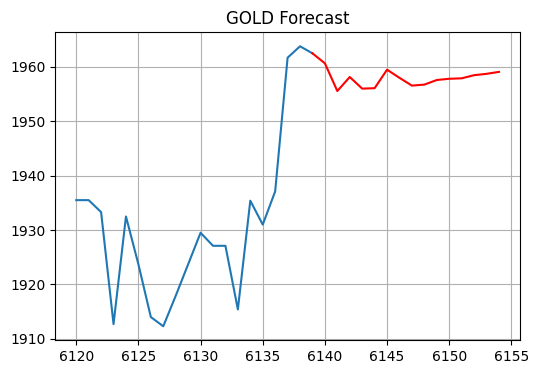

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize = (6,4))
plt.plot(combineall.iloc[6120:6140,0])
plt.plot(combineall.iloc[6139:,0],color='red')
plt.title('GOLD Forecast')
plt.grid()
plt.show()

plt.savefig('gold.png')


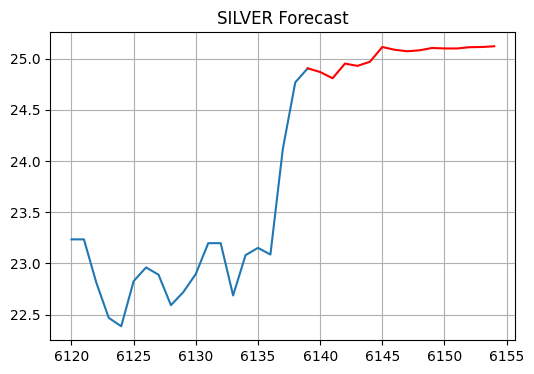

In [ ]:
                                                #Silver
plt.figure(figsize = (6,4))
plt.plot(combineall.iloc[6120:6140,4])
plt.plot(combineall.iloc[6139:,4],color='red')
plt.title('SILVER Forecast')
plt.grid()
plt.show()

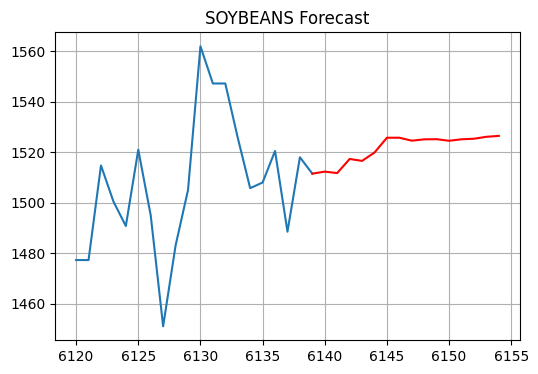

In [ ]:
                                                          #Soybeans
plt.figure(figsize = (6,4))
plt.plot(combineall.iloc[6120:6140,1])
plt.plot(combineall.iloc[6139:,1],color='red')
plt.title('SOYBEANS Forecast')
plt.grid()
plt.show()

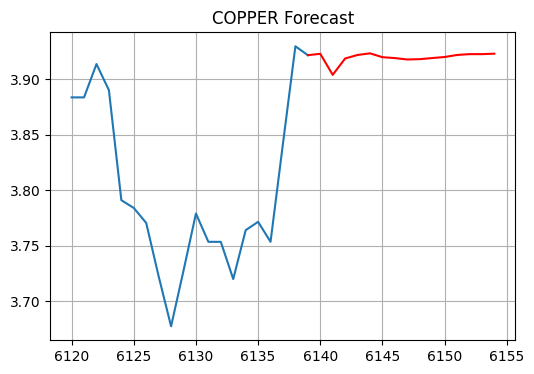

In [ ]:
                                                              #Copper
plt.figure(figsize = (6,4))
plt.plot(combineall.iloc[6120:6140,3])
plt.plot(combineall.iloc[6139:,3],color='red')
plt.title('COPPER Forecast')
plt.grid()
plt.show()

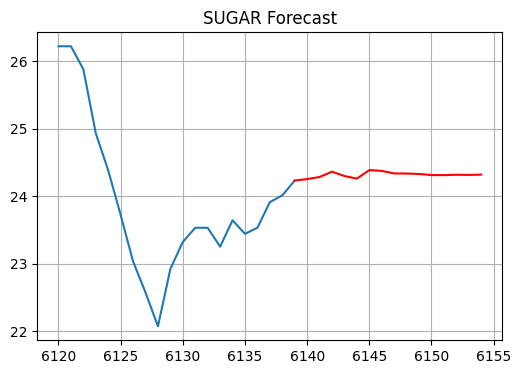

In [ ]:
                                                      #Sugar
plt.figure(figsize = (6,4))
plt.plot(combineall.iloc[6120:6140,9])
plt.plot(combineall.iloc[6139:,9],color='red')
plt.title('SUGAR Forecast')
plt.grid()
plt.show()

Lo siguiente sería tener el conocimiento cuantitativo de las medidas representativas de los errores que se están cometiendo en las predicciones.

# Evaluación del modelo

Para evaluar los pronósticos utilizaré las siguientes métricas:<br><br>
          * **MAE**, el error absoluto medio<br>
          * **RMSE**, la raíz del error cuadrático medio <br>

Estas son métricas versátiles que se pueden aplicar a una variedad de contextos, normalmente se utilizan para evaluar el rendimiento en modelos de regresión. También aplica a las series temporales, para evaluar la precisión de los modelos predictivos.

### Evaluación para el oro

In [ ]:
print('Mean absolute error:', mean_absolute_error(join_GOLD['GOLD'].values, join_GOLD['GOLD_pred'].values))

print('Root mean squared error:', np.sqrt(mean_squared_error(join_GOLD['GOLD'].values,
                                              join_GOLD['GOLD_pred'].values)))

Mean absolute error: 13.755125772201518
Root mean squared error: 15.910832980722992


### Evaluación para la plata

In [ ]:
print('Mean absolute error:', mean_absolute_error(join_SILVER['SILVER'].values,
                                                join_SILVER['SILVER_pred'].values))
print('Root mean squared error:', np.sqrt(mean_squared_error(join_SILVER['SILVER'].values,
                                                    join_SILVER['SILVER_pred'].values)))

Mean absolute error: 0.6021101877374029
Root mean squared error: 0.7522466107516659


### Evaluación para la soja

In [ ]:
print('Mean absolute error:', mean_absolute_error(join_SOYBEANS['SOYBEANS'].values,
                                              join_SOYBEANS['SOYBEANS_pred'].values))
print('Root mean squared error:', np.sqrt(mean_squared_error(join_SOYBEANS['SOYBEANS'].values,
                                                      join_SOYBEANS['SOYBEANS_pred'].values)))

Mean absolute error: 40.760592806972774
Root mean squared error: 52.91108152128767


### Evaluación para el cobre

In [ ]:
print('Mean absolute error:', mean_absolute_error(join_COPPER['COPPER'].values,
                                                join_COPPER['COPPER_pred'].values))
print('Root mean squared error:', np.sqrt(mean_squared_error(join_COPPER['COPPER'].values,
                                                      join_COPPER['COPPER_pred'].values)))

Mean absolute error: 0.06502040330662012
Root mean squared error: 0.0754637955806334


### Evaluación para el azúcar

In [ ]:
print('Mean absolute error:', mean_absolute_error(join_SUGAR['SUGAR'].values,
                                              join_SUGAR['SUGAR_pred'].values))
print('Root mean squared error:', np.sqrt(mean_squared_error(join_SUGAR['SUGAR'].values,
                                                      join_SUGAR['SUGAR_pred'].values)))


Mean absolute error: 0.3031916991993678
Root mean squared error: 0.3493785403755912


Estas son las mejores medidas de RMSE y MAE que he conseguido para cada una de las variables, hay que tener en cuenta que cuanto más bajo sean los valores de RMSE y MAE generalmente indica una mejor precisión del modelo.<br>
Para comprobar si estos valores son altos o bajos habría que tener un parámetro de comparación, es decir confrontarlo con otros modelos para evaluar su rendimiento relativo.<br>
He modificado el modelo en más de una ocación en busqueda de perfeccionarlo, llegando a la conclusión de que el modelo actual es el que manifiesta mejores resultados. Por una cuestión de optimizar el notebook y no hacerlo tan extenso, decidí no plasmar en el mismo los resultados de los restantes modelos.<br>
De manera resumida voy a comentar las modificaciones/actualizaciones que se le puede realizar al modelo actual para conseguir otros resultados:


*   Se podría comenzar a trabajar con todas las variables que tiene el csv, o seleccionar algunas de las que he dejado fuera, hacer una combinación entre ambos planteos, entre otras opciones similares.
*   Al realizar el test de causalidad de Granger y obtener como resultado una o más variables problemáticas, como en el caso de 'SOYBEANS', un camino a seguir es el de eliminar la variable y volver a comenzar. Esto implica:

1.   Eliminar dicha variable y transformar el modelo.
2.   Crear el modelo VAR con los datos transformados sin la variable problemática.

1.   Ajustar el modelo.
2.   Realizar de nuevo el test de causalidad de Granger (en caso que los valores de las variables sean los adecuados se continúa con el proceso, sino se puede optar por volver a eliminar alguna variable cuyo p-valor sea > 0.05, comenzando el ciclo nuevamente).

1.   Hallar los pronósticos.
2.   Invertir la transformación de los pronósticos a la escala original.

1.   Mostrar/graficar los resultados.
2.   Evaluar el modelo utilizando las mismas métricas para comparar los resultados con el modelo anterior.


*   Otra posibilidad es la de probar un criterio distinto a la hora de seleccionar el orden del modelo. En mi caso el que mejor ha funcionado fue el criterio AIC.


*   Otra acción que he llevado a cabo, es la de seleccionar un mayor número de observaciones para reservarlas en X_test. Cuanto más periodos hacia el futuro  selecciono --> más impreciso resulta el modelo.















